#Anime Planet // Vulpix // CS109 Final Project
Tuongvan Le, Tiffany Lee, Kelwen Peng, Dylan Tan

##Scraping Data
###Reviews and Users

In [1]:
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
import re
import string
import json
import pickle
from collections import defaultdict
from scipy.stats.stats import pearsonr
from itertools import combinations_with_replacement
from sklearn.grid_search import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.cross_validation import train_test_split
from sklearn import feature_selection
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.svm import SVC

%matplotlib inline

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

from bs4 import BeautifulSoup
# The "requests" library makes working with HTTP requests easier than the built-in urllib libraries.
import requests
from urllib2 import urlopen

In [ ]:
test1 = open("../data/anime_pages.p",'rb') 
anime = pickle.load(test1)  
test1.close()

In [ ]:
root = 'http://www.anime-planet.com'

all_anime = []
for page in anime:
    soup = BeautifulSoup(page.text, "html.parser")
    animelist = soup.find('ul',attrs={"class": "cardDeck pure-g cd-narrow"}).find_all("li")
    for ani in animelist:
        all_anime.append(root + ani.find('a').get('href'))

In [ ]:
%%time
anime_reviews = defaultdict(list)
stop = 0
for i in xrange(len(all_anime)):
    if i>=stop:
        print i
        stop+=500
    review = requests.get(all_anime[i]+"/reviews")
    soup1 = BeautifulSoup(review.text, "html.parser")
    pages = soup1.find('section',attrs={'pure-g'})
    if pages:
        pages = pages.find('div',attrs='pure-1 md-4-5')
    if pages:
        pages = pages.find('div',attrs='pagination aligncenter')
        if pages:
            all_li = pages.ul.find_all('li')
            maxpage = int(all_li[len(all_li)-2].a.contents[0])
        else:
            maxpage=1
    else:
        maxpage=1
    for j in xrange(1,maxpage+1):
        anime_reviews[all_anime[i].split('/')[-1]].append(requests.get(all_anime[i]+"/reviews?page="+str(j)))
        time.sleep(1)

In [ ]:
#pickle.dump(anime_reviews, open("../data/anime_reviews1.p", "wb"))

test3 = open("../data/anime_reviews1.p",'rb') 
anime_reviews = pickle.load(test3)  
test3.close()

In [ ]:
reviewsdict = {}
for anime in anime_reviews.keys():
    animedict = {anime:{}}
    for a in range(len(anime_reviews[anime])):
        soup = BeautifulSoup(anime_reviews[anime][a].text, "html.parser")
        body = soup.find('div',attrs={"class": "pure-1 md-4-5"})
        if body is not None:
            sections = body.find_all('section', attrs={'class':'pure-g'})
            names = [i.find('a',attrs={'itemprop':'author'}).contents[0] for i in sections if i.find('a',attrs={'itemprop':'author'}) is not None]
            scores = [i.find_all('div',attrs={'class':'pure-1-5'}) for i in sections if i.find_all('div',attrs={'class':'pure-1-5'}) != []]
            story = [i[0].contents[0] for i in scores]
            animation = [i[1].contents[0] for i in scores]
            sound = [i[2].contents[0] for i in scores]
            characters = [i[3].contents[0] for i in scores]
            overall = [i[4].contents[0] for i in scores]
            reviews = [i.contents[1].string for i in body.find_all('section', attrs={'class':'userContent readMore'})]
            anime_name = soup.find('h1',attrs={"itemprop": "name"}).contents*len(names)
            temp = dict(zip(names,zip(story,animation,sound,characters,overall,reviews,anime_name)))
            animedict[anime].update(temp)
    reviewsdict.update(animedict)


In [ ]:
with open('../data/all_reviews.json', 'w') as fp:
      json.dump(reviewsdict, fp)

with open('../data/all_reviews.json','r') as data_file:    
    reviewsdict = json.load(data_file)

In [ ]:
reviewlist = []
for i in reviewsdict.keys():
    reviewlist+=reviewsdict[i].keys()
users = list(set(reviewlist))

In [ ]:
len(users),len(reviewlist)

In [ ]:
newlist = []

for key in reviewsdict:
    for user in reviewsdict[key]:
        story = reviewsdict[key][user][0]
        animation = reviewsdict[key][user][1]
        sound = reviewsdict[key][user][2]
        character = reviewsdict[key][user][3]
        overall = reviewsdict[key][user][4]
        reviews = reviewsdict[key][user][5]
        anime_name = reviewsdict[key][user][6]
        temp = {"name":user,'anime':key,'story':story,'animation':animation,'sound':sound,'character':character,'overall':overall,'reviews':reviews,'anime_name':anime_name}
        newlist.append(temp)

In [ ]:
newdata = pd.DataFrame(newlist)
newdata.shape

In [ ]:
newdata.to_csv('../data/all_reviews.csv',sep='\t',encoding='utf-8')

In [ ]:
#newdata.loc[:,['anime','anime_name']].to_csv('../data/anime_name.csv',sep='\t',encoding='utf-8')

#### Getting User Profile

In [ ]:
%%time
root = 'http://www.anime-planet.com/users/'
user_profiles = {}
for i in xrange(len(users)):
    user = requests.get(root+users[i])
    soup = BeautifulSoup(user.text, "html.parser")
    user_profiles[users[i]]=soup
    time.sleep(1)

In [ ]:
each_user_info = {}

for user in user_profiles.keys():
    test = user_profiles[user]
    user_info = {}

    info = test.find('div',attrs={'class':'pure-u-3-5 pure-u-md-4-5'})
    name = info.find('h2',attrs={'id':'profileName'}).find_all('a')[1].contents[0]

    stats = info.find('ul',attrs={'class':'userStats'}).findAll('li')
    place = ""
    age_sex = ""
    join = ""

    # find place, age, sex if exist
    for li in stats:
        if li.findAll(attrs={"class" : "fa fa-home"}):
            place = li.contents[1]
        elif li.findAll(attrs={"class" : "fa fa-calendar"}):
            join = li.contents[1]
        elif li.findAll(attrs={"class" : "fa fa-user"}):
            age_sex = li.contents[2].replace('\n','')

    each_user_info[name] = {"place":place,"age_sex":age_sex,"join":join}

In [ ]:
# with open('../data/all_users.json', 'w') as fp:
#        json.dump(each_user_info, fp)

with open('../data/all_users.json','r') as data_file:    
    each_user_info = json.load(data_file)

In [ ]:
userdf = pd.DataFrame(each_user_info).T

In [ ]:
userdf.to_csv('../data/all_users.csv',sep='\t',encoding='utf-8')

###Anime Data

In [ ]:
# import pip

# def install(package):
#    pip.main(['install', package])

# install('python-mal')

# import myanimelist.session
# #username="teamvulpix", password="2015harvardcs109"
# session = myanimelist.session.Session()
# session.login()
# bebop = session.anime(20)

#### Scraping the search bar of www.anime-planet.com

In [ ]:
#48 animes per page with 152 pages = ~7296
anime = []
for i in xrange(1,153):
    anime.append(requests.get('http://www.anime-planet.com/anime/all?sort=title&order=asc&page='+str(i)))
    time.sleep(1)

#### Finding all anime links

In [ ]:
root = 'http://www.anime-planet.com'

all_anime = []
for page in anime:
    soup = BeautifulSoup(page.text, "html.parser")
    animelist = soup.find('ul',attrs={"class": "cardDeck pure-g cd-narrow"}).find_all("li")
    for ani in animelist:
        all_anime.append(root + ani.find('a').get('href'))

#### Requesting each anime page information

In [ ]:
each_anime = []

for i in xrange(len(all_anime)):
    each_anime.append(requests.get(all_anime[i]))
    time.sleep(1)

####Getting info from each anime

In [ ]:
each_anime_info = {}

for anim in each_anime:
    anime_info = {}
    soup1 = BeautifulSoup(anim.text, "html.parser")
    name = soup1.find('h1',attrs={"itemprop": "name"}).contents[0]
    altname = soup1.find('h2',attrs={"class": "aka"})

    infos = soup1.find_all('div',attrs={"class": "pure-u-1 pure-u-md-1-5"})
    atype = infos[0]
    studio = infos[1].a
    date = infos[2].li
    date_pub = infos[2].find('span',attrs={'itemprop':'datePublished'})
    rating = infos[3].div.span
    rank = infos[4]
    description = soup1.find('div',attrs={"itemprop": "description"})
    
    #get categories
    categories_table = soup1.find('div',attrs={"class": "categories"})
    if categories_table is not None:
        anime_info['categories'] = [i.a.contents[0] for i in categories_table.ul]
    
    #get related media
    related_table = soup1.find('table',attrs={"class": "pure-table pure-table-striped noHeader"})
    if related_table is not None:
        anime_info['related'] = [row.td.a.contents[0] for row in related_table.find_all('tr')]
    
    anime_info['name'] = name
    if altname is not None:
        anime_info['altname'] = altname.contents[0]
    else:
        anime_info['altname'] = ''
    if atype is not None:
        anime_info['atype'] = atype.contents[0]
    else:
        anime_info['atype'] = ''
    if studio is not None:
        anime_info['studio'] = studio.contents[0]
    else:
        anime_info['studio'] = ''
    if date is not None:
        anime_info['date'] = date.a.contents[0]
    else:
        anime_info['date'] = ''
    if date_pub is not None:
        anime_info['date_pub'] = date_pub.a.contents[0]
    else:
        anime_info['date'] = ''
    if rating is not None:
        anime_info['rating'] = rating.contents[0]
    else:
        anime_info['rating'] = ''
    if rank is not None:
        anime_info['rank'] = rank.contents[0]
    else:
        anime_info['rank'] = ''
    if description is not None :
        if description.p is not None:
            anime_info['description'] = description.p.contents[0].string
        else:
                anime_info['description'] = ''
    else:
        anime_info['description'] = ''
    
    if name in each_anime_info.keys():
        name+='_2'
        
    each_anime_info[name] = anime_info

In [ ]:
#  with open('each_anime_info.json', 'w') as fp:
#      json.dump(each_anime_info, fp)

with open('../data/each_anime_info.json','r') as data_file:    
    each_anime_info = json.load(data_file)
    
anime_info = pd.DataFrame(each_anime_info).T
anime_info.head()

In [ ]:
#anime_info.to_csv('../data/anime_info.csv',sep='\t',encoding='utf-8')
anime_info = pd.read_csv('../data/anime_info.csv',sep='\t',index_col=0)
anime_info.head()

#Data Cleaning

In [2]:
reviews = pd.read_csv('../data/all_reviews.csv',sep='\t',encoding='utf-8', index_col=0)
users = pd.read_csv('../data/all_users.csv',sep='\t',encoding='utf-8', index_col=0)
data = pd.read_csv("../data/anime_info.csv",sep='\t', index_col=0)

## Reviews

In [ ]:
# removing extraneous spaces/chars
reviews.animation = reviews.animation.str.strip().str[0:-3].convert_objects(convert_numeric=True)
reviews.character = reviews.character.str.strip().str[0:-3].convert_objects(convert_numeric=True)
reviews.overall = reviews.overall.str.strip().str[0:-3].convert_objects(convert_numeric=True)
reviews.sound = reviews.sound.str.strip().str[0:-3].convert_objects(convert_numeric=True)
reviews.story = reviews.story.str.strip().str[0:-3].convert_objects(convert_numeric=True)

## Users

In [ ]:
for i in users.index:
    temp = users.ix[i,'age_sex'].strip().split('/')
    age = '?'
    sex = '?'
    
    # check if user has provided age/sex
    if len(temp)==2:
        age = temp[0]
        sex = temp[1]  
    elif temp[0].isdigit():
        age = temp[0]
    else:
        sex = temp[0]
        
    users.ix[i,'age']=age
    users.ix[i,'sex']=sex
    
# remove those without age/sex
subusers = users.loc[(users.age!='? ')&(users.sex!='?')]
print subusers.shape
subusers.head()

### Combining user and review information

In [ ]:
# remove reviews whose user is not in user database
mask = [i in subusers.index for i in reviews.name]
subreviews = reviews.loc[mask]

# match age and sex info to reviews
age = []
sex = []

for i in subreviews.index:
    age.append(int(subusers.ix[subreviews.ix[i,'name'],'age']))
    sex.append(subusers.ix[subreviews.ix[i,'name'],'sex'])
    
subreviews.loc[:,'age']=age
subreviews.loc[:,'sex']=sex

subreviews.head()

In [ ]:
# replace missing information with random sex and average age
mean_age = subreviews.age.mean()

age = []
sex = []

final = reviews.copy()

for i in final.index:
    name = final.ix[i,'name']
    if name in subusers.index:
        age.append(int(subusers.ix[name,'age']))
        sex.append(subusers.ix[name,'sex'].strip())
    else:
        age.append(mean_age)
        ran = np.random.random_integers(0,high=1)
        if ran==1:
            sex.append('M')
        else:
            sex.append('F')
        
    
final.loc[:,'age']=age
final.loc[:,'sex']=sex

final.head()

In [ ]:
for i,val in enumerate(final.anime_name):
    if val == 'Beyblade: G Revolution':
        final.ix[i,'anime_name']='Beyblade G Revolution'
    if val == 'Beyblade: V-Force':
        final.ix[i,'anime_name']='Beyblade V-Force'
    if val == 'Beyblade: The Movie':
        final.ix[i,'anime_name']='Beyblade - The Movie'
        
# reordering columns
final = final[['anime', 'anime_name', 'name', 'age', 'sex', 'reviews', 'overall', 'animation', 'character', 'sound', 'story']]

####Adding category indicators

In [ ]:
names = []
for i in data.index:
    names.append(i.encode('ascii', 'ignore'))
data.index=names

# checking how many unique categories
genres = data.categories.tolist()

temp = []
for i in genres:
    if type(i)==str:
        temp+=i.replace('[','').replace(']','').replace(' ','').split(',')
uniq_genres = list(set(temp))
len(uniq_genres)

In [ ]:
# changing categories from string to list
temp = []
genres = data.categories.tolist()
for i in genres:
    if type(i)==str:
        temp.append(i.replace('[','').replace(']','').replace(' ','').split(','))
    else:
        temp.append([])
data.loc[:,'categories_list'] = temp

# finding categories
categories = defaultdict(list)
for i in final.anime_name:
    cat = data.loc[i.encode('ascii', 'ignore'),'categories_list']
    for j in cat:
        categories[j].append(1)
    for k in uniq_genres:
        if k not in cat:
            categories[k].append(0)
            
# add categories to final
for i in categories:
    final.loc[:,i] = categories[i]

In [ ]:
per = final.shape[0]*0.005
mask = (final.ix[:,11:].sum(axis=0)>per)

for i in final.columns[11:]:
    check = mask[i]
    if not check:
        final.drop(i,axis=1,inplace=True)

In [ ]:
final.to_csv('../data/final_review.csv')

##Anime

First Step: 
    1. Within "rating", select ranking out of 5 and pick out number of votes. 
    2. Add separate columns of rating and votes into df
    3. Remove old rating column
    4. Draw histogram of frequency of rating (out of 5)

In [3]:
# select vote and numerical ratings within "rating", set rating=0 if doesn't exist
votes=[]
ratings=[]
for row in data.index:
    l=data.ix[row,"rating"].split(" ")
    temp_v=(l[4]).replace(",","")
    # take out "__ needed to calculate an average" in "rating" column
    if (temp_v=="an"):
        ratings.append(0)
        votes.append(0)
    else: 
        votes.append(int(temp_v))
        ratings.append(float(l[0].replace(",","")))

In [4]:
# append new columns of votes and ratings for each anime
data["votes"]=votes
data["ratings"]=ratings

In [5]:
# remove rating
data.drop("rating", axis=1)
data.head(5)

,altname,atype,categories,date,date_pub,description,name,rank,rating,related,studio,votes,ratings
(Making of) Evangelion: Another Impact,NaN,\n Web (1 ep x 6 min),"[Sci Fi, CG Animation, Japan Animator's Exhibi...",NaN,2015,"This episode is a making film of #12 ""evangeli...",(Making of) Evangelion: Another Impact,"\n Rank #5,996",1.743 of 5 from 153 votes,"[Neon Genesis Evangelion, Neon Genesis Evangel...",Studio Khara,153,1.743
+A-Channel,NaN,\nDVD Special (11 eps x 2 min),"[Comedy, Slice of Life, Based on a Manga]",NaN,2011,There are many untold stories in the lives of ...,+A-Channel,"\n Rank #2,398","3.334 of 5 from 1,192 votes","[A-Channel, A-Channel + smile]",Studio Gokumi,1192,3.334
.hack//G.U. Returner,NaN,\nOVA (1 ep),"[MMORPG, RPG, Virtual Reality]",NaN,2007,"""There is something I wish to entrust to you; ...",.hack//G.U. Returner,"\n Rank #2,504","3.291 of 5 from 2,021 votes","[.hack//SIGN, .hack//LIMINALITY, .hack//Legend...",NaN,2021,3.291
.hack//G.U. Trilogy,NaN,\nMovie (1 ep x 93 min),"[CG Animation, MMORPG, RPG, Virtual Reality]",NaN,2008,The World is an ordinary online game – or at l...,.hack//G.U. Trilogy,"\n Rank #1,576","3.671 of 5 from 2,814 votes","[.hack//SIGN, .hack//LIMINALITY, .hack//Legend...",NaN,2814,3.671
.hack//G.U. Trilogy Parody,NaN,\nDVD Special (1 ep x 6 min),"[Comedy, MMORPG, RPG, Virtual Reality]",NaN,2008,NaN,.hack//G.U. Trilogy Parody,"\n Rank #3,993",2.691 of 5 from 714 votes,"[.hack//SIGN, .hack//LIMINALITY, .hack//Legend...",NaN,714,2.691


Step 2:
    1. Under "rank" column, pick out numerical rank, set rank=-1 if rank is NaN
    2. Drop old rank column, add new column of "rank" which only includes numerical values

In [6]:
# pick out numerical rank, rank= -1 if rank=NULL
ranks=[]
for row in data.index:
    l=data.ix[row,"rank"].split("#",1)
    if (len(l)>1):
        ranks.append(int(l[1].replace(",","")))
    else:
        ranks.append(-1)

In [7]:
# drop rank column
# add new rank column with numerical values only
# data.drop("rank", axis=1)
data["rank"]=ranks

Step 3:
    1. Under column atype, pick out number of episodes and length of episodes, calculate total length of movies
    2. Add new column "tlength" to indicate length of anime movies

In [8]:
# pick out number of episodes for each movie, episodes=0 if doesn't exist
episodes=[]
for row in data.index:
    l=data.ix[row,"atype"].split("(",1)
    if (len(l)>1):
        n=l[1:]
        m=n[0].split(" ")
        episodes.append(int(m[0].replace("+","")))
    else:
        episodes.append(0)

In [9]:
# Amend episodes column into dataframe
data["eps"]=episodes
data.head(5)

,altname,atype,categories,date,date_pub,description,name,rank,rating,related,studio,votes,ratings,eps
(Making of) Evangelion: Another Impact,NaN,\n Web (1 ep x 6 min),"[Sci Fi, CG Animation, Japan Animator's Exhibi...",NaN,2015,"This episode is a making film of #12 ""evangeli...",(Making of) Evangelion: Another Impact,5996,1.743 of 5 from 153 votes,"[Neon Genesis Evangelion, Neon Genesis Evangel...",Studio Khara,153,1.743,1
+A-Channel,NaN,\nDVD Special (11 eps x 2 min),"[Comedy, Slice of Life, Based on a Manga]",NaN,2011,There are many untold stories in the lives of ...,+A-Channel,2398,"3.334 of 5 from 1,192 votes","[A-Channel, A-Channel + smile]",Studio Gokumi,1192,3.334,11
.hack//G.U. Returner,NaN,\nOVA (1 ep),"[MMORPG, RPG, Virtual Reality]",NaN,2007,"""There is something I wish to entrust to you; ...",.hack//G.U. Returner,2504,"3.291 of 5 from 2,021 votes","[.hack//SIGN, .hack//LIMINALITY, .hack//Legend...",NaN,2021,3.291,1
.hack//G.U. Trilogy,NaN,\nMovie (1 ep x 93 min),"[CG Animation, MMORPG, RPG, Virtual Reality]",NaN,2008,The World is an ordinary online game – or at l...,.hack//G.U. Trilogy,1576,"3.671 of 5 from 2,814 votes","[.hack//SIGN, .hack//LIMINALITY, .hack//Legend...",NaN,2814,3.671,1
.hack//G.U. Trilogy Parody,NaN,\nDVD Special (1 ep x 6 min),"[Comedy, MMORPG, RPG, Virtual Reality]",NaN,2008,NaN,.hack//G.U. Trilogy Parody,3993,2.691 of 5 from 714 votes,"[.hack//SIGN, .hack//LIMINALITY, .hack//Legend...",NaN,714,2.691,1


In [10]:
# pick out minutes per episode, emin=0 if does not exist
emin=[]
for row in data.index:
    l=data.ix[row,"atype"].split("x",1)
    if (len(l)>1):
        n=l[1:]
        m=n[0].split(" ")
        emin.append(int(m[1]))
    else:
        emin.append(0)

In [11]:
# add emin (minutes per episode) into dataframe
data["emin"]=emin
data.head(5)

,altname,atype,categories,date,date_pub,description,name,rank,rating,related,studio,votes,ratings,eps,emin
(Making of) Evangelion: Another Impact,NaN,\n Web (1 ep x 6 min),"[Sci Fi, CG Animation, Japan Animator's Exhibi...",NaN,2015,"This episode is a making film of #12 ""evangeli...",(Making of) Evangelion: Another Impact,5996,1.743 of 5 from 153 votes,"[Neon Genesis Evangelion, Neon Genesis Evangel...",Studio Khara,153,1.743,1,6
+A-Channel,NaN,\nDVD Special (11 eps x 2 min),"[Comedy, Slice of Life, Based on a Manga]",NaN,2011,There are many untold stories in the lives of ...,+A-Channel,2398,"3.334 of 5 from 1,192 votes","[A-Channel, A-Channel + smile]",Studio Gokumi,1192,3.334,11,2
.hack//G.U. Returner,NaN,\nOVA (1 ep),"[MMORPG, RPG, Virtual Reality]",NaN,2007,"""There is something I wish to entrust to you; ...",.hack//G.U. Returner,2504,"3.291 of 5 from 2,021 votes","[.hack//SIGN, .hack//LIMINALITY, .hack//Legend...",NaN,2021,3.291,1,0
.hack//G.U. Trilogy,NaN,\nMovie (1 ep x 93 min),"[CG Animation, MMORPG, RPG, Virtual Reality]",NaN,2008,The World is an ordinary online game – or at l...,.hack//G.U. Trilogy,1576,"3.671 of 5 from 2,814 votes","[.hack//SIGN, .hack//LIMINALITY, .hack//Legend...",NaN,2814,3.671,1,93
.hack//G.U. Trilogy Parody,NaN,\nDVD Special (1 ep x 6 min),"[Comedy, MMORPG, RPG, Virtual Reality]",NaN,2008,NaN,.hack//G.U. Trilogy Parody,3993,2.691 of 5 from 714 votes,"[.hack//SIGN, .hack//LIMINALITY, .hack//Legend...",NaN,714,2.691,1,6


In [12]:
t_length=[]
for i in range(0,len(emin)):
    t_length.append(int(emin[i])*int(episodes[i]))

In [13]:
# adding total length of anime movies to column
data["tlength"]=t_length
data.head(5)

,altname,atype,categories,date,date_pub,description,name,rank,rating,related,studio,votes,ratings,eps,emin,tlength
(Making of) Evangelion: Another Impact,NaN,\n Web (1 ep x 6 min),"[Sci Fi, CG Animation, Japan Animator's Exhibi...",NaN,2015,"This episode is a making film of #12 ""evangeli...",(Making of) Evangelion: Another Impact,5996,1.743 of 5 from 153 votes,"[Neon Genesis Evangelion, Neon Genesis Evangel...",Studio Khara,153,1.743,1,6,6
+A-Channel,NaN,\nDVD Special (11 eps x 2 min),"[Comedy, Slice of Life, Based on a Manga]",NaN,2011,There are many untold stories in the lives of ...,+A-Channel,2398,"3.334 of 5 from 1,192 votes","[A-Channel, A-Channel + smile]",Studio Gokumi,1192,3.334,11,2,22
.hack//G.U. Returner,NaN,\nOVA (1 ep),"[MMORPG, RPG, Virtual Reality]",NaN,2007,"""There is something I wish to entrust to you; ...",.hack//G.U. Returner,2504,"3.291 of 5 from 2,021 votes","[.hack//SIGN, .hack//LIMINALITY, .hack//Legend...",NaN,2021,3.291,1,0,0
.hack//G.U. Trilogy,NaN,\nMovie (1 ep x 93 min),"[CG Animation, MMORPG, RPG, Virtual Reality]",NaN,2008,The World is an ordinary online game – or at l...,.hack//G.U. Trilogy,1576,"3.671 of 5 from 2,814 votes","[.hack//SIGN, .hack//LIMINALITY, .hack//Legend...",NaN,2814,3.671,1,93,93
.hack//G.U. Trilogy Parody,NaN,\nDVD Special (1 ep x 6 min),"[Comedy, MMORPG, RPG, Virtual Reality]",NaN,2008,NaN,.hack//G.U. Trilogy Parody,3993,2.691 of 5 from 714 votes,"[.hack//SIGN, .hack//LIMINALITY, .hack//Legend...",NaN,714,2.691,1,6,6


Step 4: 
    1. Under "atype" column, pick out the type of anime, reset column "type" to include the type only
    2. Under "studio" column, calculate frequency of appearance of studio producing the rated animes
    3. Draw a histogram of frequency of studios

In [14]:
# pick out type of anime
types=[]
for row in data.index:
    l=data.ix[row,"atype"].split("(",1)
    if (len(l)>1):
        types.append(l[0])
    else:
        types.append("NA")

In [15]:
data["type"]=types

Step 5:
    1. Clean "ratings" column by removing non-numerical values, set -1 if there is not enough data
    2. Groupby Studios, calculate ratings of studious, rank average ratings in descending order
    3. Groupby Studios, calculate rankings of studios, rank average ranings in descending order
    4. Compare frequency, ratings, and rankings' correlations among studios

In [16]:
# some ratings said "6 needed to calculate average". Set ratings for these equal to -1
for row in data.index:
    l=data.ix[row,"ratings"]
    if l>5:
        l=-1
        data.ix[row,"ratings"]=l

Step 6:
    1. Clean "atype" column, calculate frequency of types of animes
    2. Groupby type of anime, calculate average ratings for each type, rank average ratings in descending order
    3. Groupby type of anime, calculate average rankings for each type, rank average rankings in descending order
    4. Observe correlations of top types by ratings, rankings, and frequency

In [17]:
# remove trailing spaces in type
for row in data.index:
    l=data.ix[row,"type"].strip(" ")
    l=l.replace(" ","")
    data.ix[row,"type"]=l

#Data Exploration

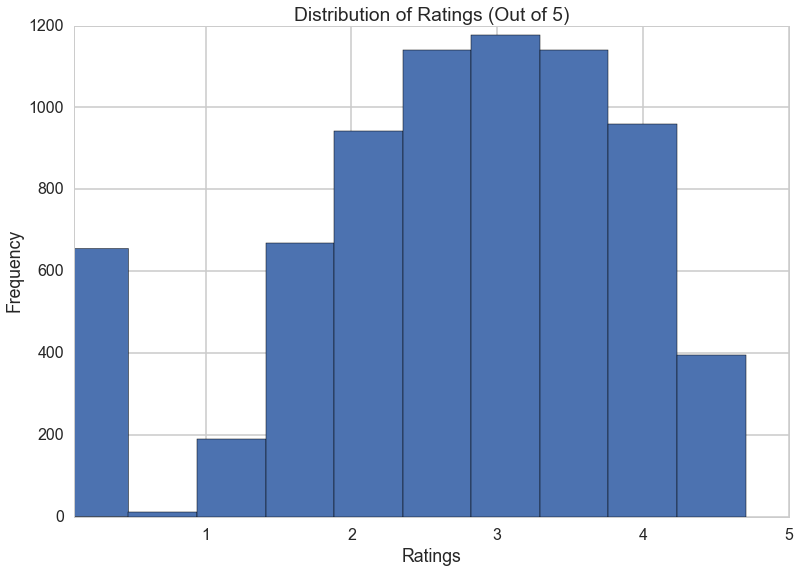

In [18]:
# Ratings distribution
plt.hist(data["ratings"])
plt.title("Distribution of Ratings (Out of 5)")
plt.ylabel("Frequency")
plt.xlabel("Ratings")
plt.xlim(0.1,5.0)
plt.show()

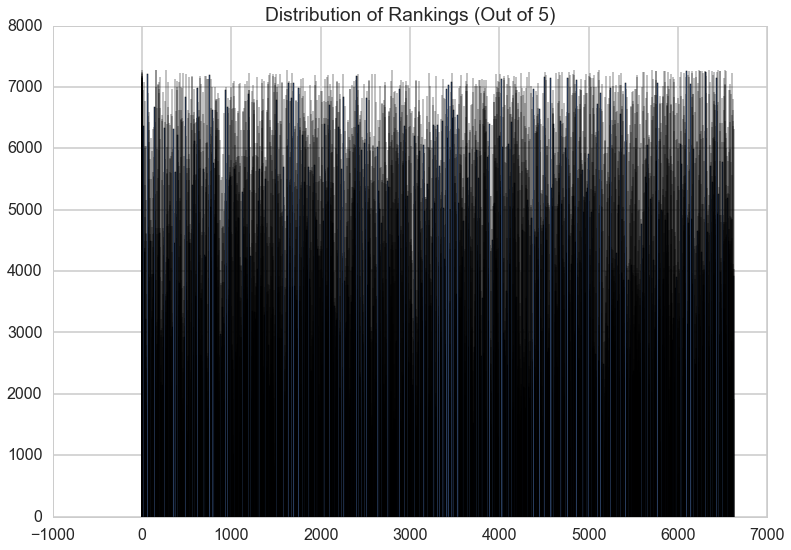

In [19]:
# Rankings distribution
plt.bar(data["rank"], np.arange(len(data["rank"])))
plt.title("Distribution of Rankings (Out of 5)")
plt.show()

In [20]:
# Frequency of Studios
a=pd.value_counts(data['studio'].values, sort=True)
subd=pd.DataFrame(a,a.index.values)
subd.columns=['Frequency']
subd.head(5)

,Frequency
Toei Animation,494
Sunrise,341
MADHOUSE,258
J.C.Staff,245
TMS Entertainment,209


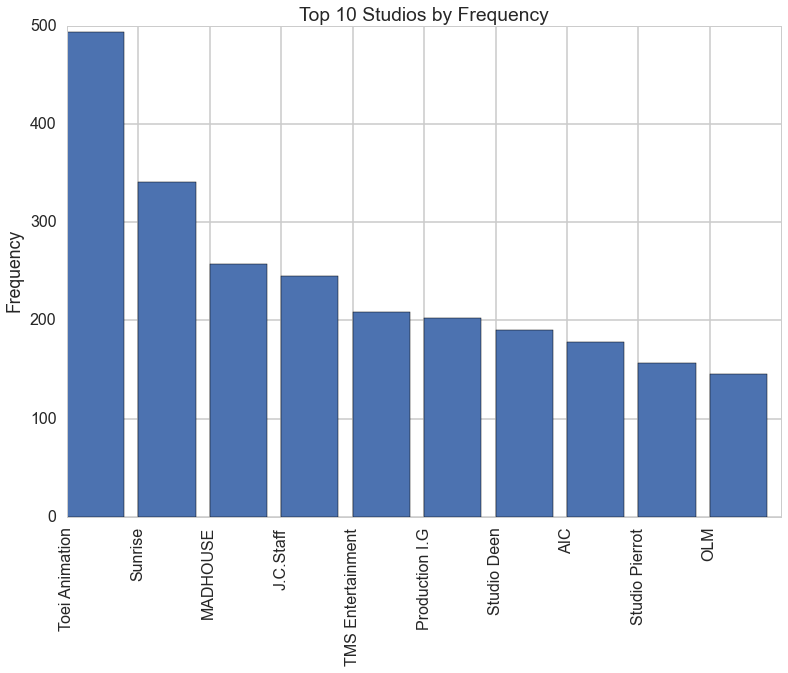

In [21]:
# PLOT TOP 10 STUDIOS BY FREQUENCY
x=np.arange(10)
plt.bar(x,subd.ix[0:10,'Frequency'])
plt.xticks(x, a.index.values[0:10], rotation='vertical')
plt.title("Top 10 Studios by Frequency")
plt.ylabel("Frequency")
plt.show()

In [22]:
# arrange studio by highest average ratings
studio_r=data.groupby("studio").aggregate(np.mean)["ratings"]
studio_r=studio_r.order(ascending=False)
subd_studio=pd.DataFrame(studio_r,a.index.values)
subd_studio.columns=['Average Ratings']
subd_studio = subd_studio.sort(['Average Ratings'], ascending=False)
subd_studio.head(5)

,Average Ratings
IMAGIN,4.38800
Studio Chizu,4.38400
Studio Wombat,4.35500
Purple Cow Studio Japan,4.19600
Studio Rikka,4.05825


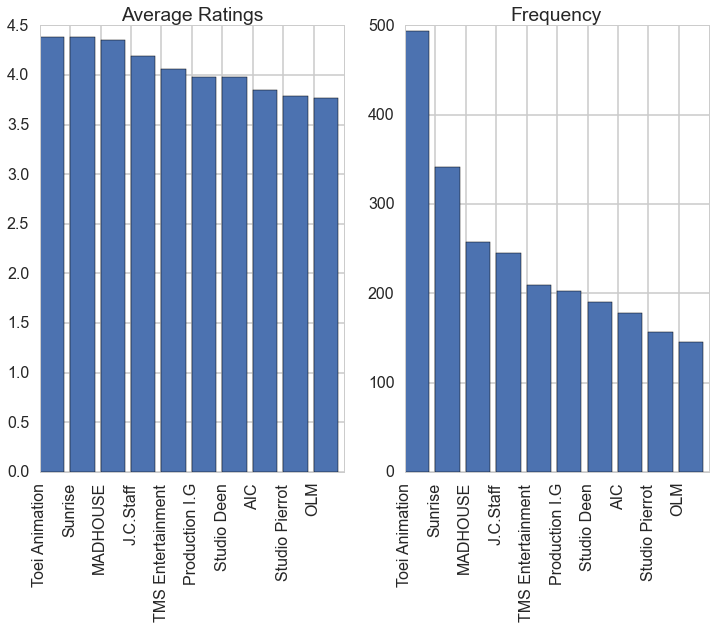

In [23]:
# PLOT STUDIOS BY FREQUENCY AND AVERAGE RATINGS FOR COMPARISONS

fig, axes= plt.subplots(nrows=1, ncols=2, figsize=(12,8))
x=np.arange(10)
axes[0].bar(x,subd_studio.ix[0:10,'Average Ratings'])
axes[0].set_title('Average Ratings')
axes[0].set_xticks(x)
axes[0].set_xticklabels(a.index.values[0:10], rotation=90)
axes[0].set_xticks(x)
axes[0].set_xticklabels(a.index.values[0:10], rotation=90)
axes[1].bar(x,subd.ix[0:10,'Frequency'])
axes[1].set_title('Frequency')
axes[1].set_xticks(x)
axes[1].set_xticklabels(a.index.values[0:10], rotation=90)

In [24]:
# arrange studio by highest average ranks
studio_rank=data.groupby("studio").aggregate(np.mean)["rank"]
subd_studio_rank=pd.DataFrame(studio_rank,a.index.values)
subd_studio_rank.columns=['Average Rankings']
subd_studio_rank = subd_studio_rank.sort(['Average Rankings'], ascending=True)
subd_studio_rank.head(5)

,Average Rankings
Kyowa Film,-1
Orange,-1
Automatic Flowers Studio,-1
IMOVE,-1
Buemon,-1


In [25]:
subd_studio_rank.ix[0:10,'Average Rankings']

Kyowa Film                   -1.0
Orange                       -1.0
Automatic Flowers Studio     -1.0
IMOVE                        -1.0
Buemon                       -1.0
Pie in the sky               -1.0
Pine Jam                     -1.0
Shuka                       126.8
IMAGIN                      171.0
Studio Wombat               219.0
Name: Average Rankings, dtype: float64

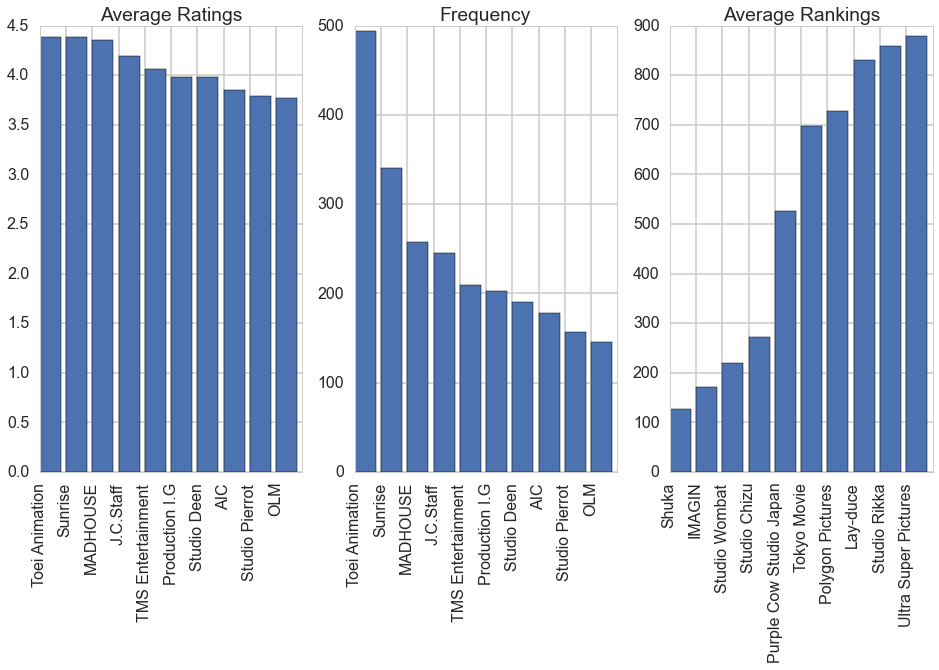

In [26]:
# PLOT TOP 10 STUDIOS BY FREQUENCY, AVERAGE RANKINGS, AND AVERAGE RATINGS FOR COMPARISONS

fig, axes= plt.subplots(nrows=1, ncols=3, figsize=(16,8))
x=np.arange(10)
axes[0].bar(x,subd_studio.ix[0:10,'Average Ratings'])
axes[0].set_title('Average Ratings')
axes[0].set_xticks(x)
axes[0].set_xticklabels(a.index.values[0:10], rotation=90)
axes[1].bar(x,subd.ix[0:10,'Frequency'])
axes[1].set_title('Frequency')
axes[1].set_xticks(x)
axes[1].set_xticklabels(a.index.values[0:10], rotation=90)
axes[2].bar(x,subd_studio_rank.ix[7:17,'Average Rankings']) # first 7 have -1 ranking, or no ranking
axes[2].set_title('Average Rankings')
axes[2].set_xticks(x)
axes[2].set_xticklabels(subd_studio_rank.index.values[7:17], rotation=90)

In [27]:
# Frequency of types
t=pd.value_counts(data['type'].values, sort=True)
subd_t=pd.DataFrame(t,t.index.values)
subd_t.columns=['Frequency']
subd_t.head(5)

,Frequency
\nTV,2715
\nOVA,1450
\nMovie,1239
\nDVDSpecial,528
\nMusicVideo,328


In [28]:
# Type vs ratings
type_rating=data.groupby("type").aggregate(np.mean)["ratings"]
type_rating=type_rating.order(ascending=False)
subd_type_rating=pd.DataFrame(type_rating,type_rating.index.values)
subd_type_rating.columns=['Average Ratings']
subd_type_rating = subd_type_rating.sort(['Average Ratings'], ascending=False)
subd_type_rating.head(5)

,Average Ratings
\nTV,2.980532
\nTVSpecial,2.864709
\nDVDSpecial,2.861572
\nOVA,2.717472
\nMovie,2.710854


In [29]:
# Type vs rankings
type_rank=data.groupby("type").aggregate(np.mean)["rank"]
type_rank=type_rank.order(ascending=False)
subd_type_rank=pd.DataFrame(type_rank,type_rating.index.values)
subd_type_rank.columns=['Average Rankings']
subd_type_rank = subd_type_rank.sort(['Average Rankings'], ascending=True)
subd_type_rank.head(5)

,Average Rankings
NA,10.949367
\nMovie,2745.891848
\nTVSpecial,2779.708904
\nTV,2786.073665
\nDVDSpecial,3174.492424


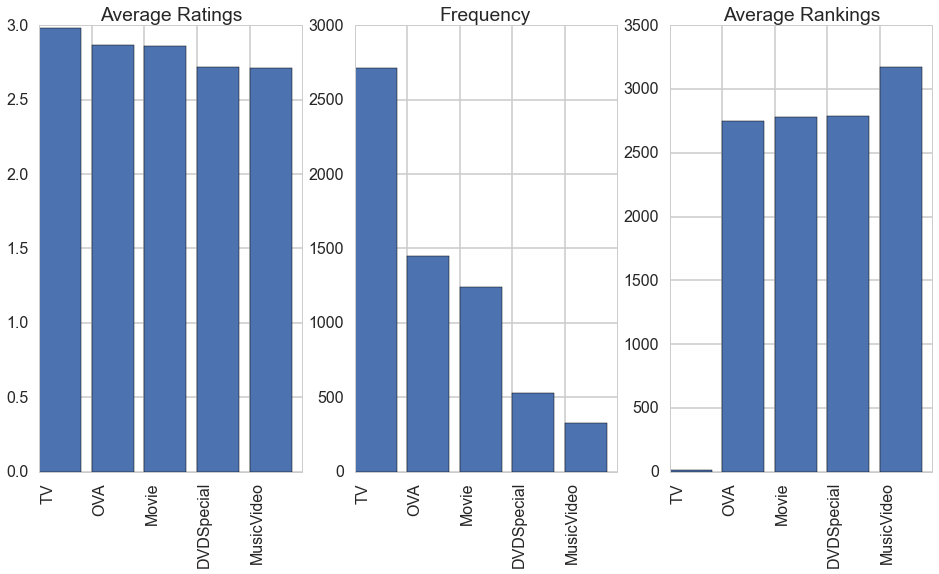

In [30]:
# PLOT TOP 5 TYPES BY FREQUENCY, AVERAGE RANKINGS, AND AVERAGE RATINGS FOR COMPARISONS

fig, axes= plt.subplots(nrows=1, ncols=3, figsize=(16,8))
x=np.arange(5)
axes[0].bar(x,subd_type_rating.ix[0:5,'Average Ratings'])
axes[0].set_title('Average Ratings')
axes[0].set_xticks(x)
axes[0].set_xticklabels(t.index.values[0:5], rotation=90)
axes[1].bar(x,subd_t.ix[0:5,'Frequency'])
axes[1].set_title('Frequency')
axes[1].set_xticks(x)
axes[1].set_xticklabels(t.index.values[0:5], rotation=90)
axes[2].bar(x,subd_type_rank.ix[0:5,'Average Rankings'])
axes[2].set_title('Average Rankings')
axes[2].set_xticks(x)
axes[2].set_xticklabels(t.index.values[0:5], rotation=90)

Step 7: 
    1. Scatter tlength and ratings to find any correlation
    2. Scatter tlength and rankings to find any correlation
    3. Observe and record any correlation

In [31]:
# Tlength vs ratings
subd_length=pd.DataFrame(data["tlength"], data.index.values)
subd_length["ratings"]=data["ratings"]
subd_length

,tlength,ratings
(Making of) Evangelion: Another Impact,6,1.743
+A-Channel,22,3.334
.hack//G.U. Returner,0,3.291
.hack//G.U. Trilogy,93,3.671
.hack//G.U. Trilogy Parody,6,2.691
.hack//GIFT,0,2.646
.hack//LIMINALITY,0,3.064
.hack//Legend Of The Twilight,0,3.078
.hack//Quantum,0,3.933
.hack//Quantum Specials,9,2.916


In [32]:
subd_length.tlength.max()

18080

/Users/tiffanylee/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


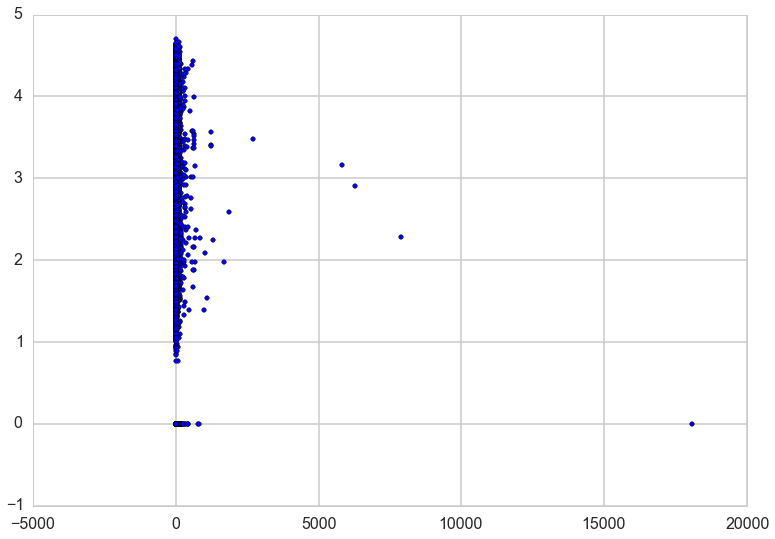

In [33]:
plt.scatter(subd_length["tlength"], subd_length["ratings"])

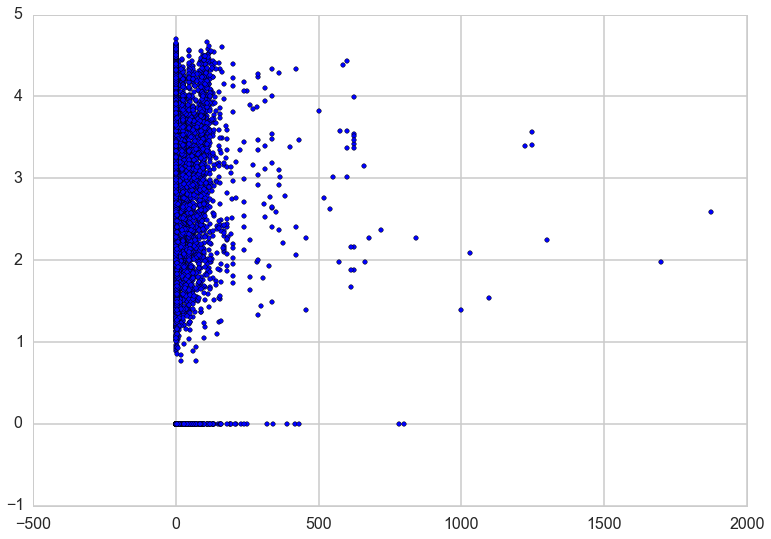

In [34]:
# zoom in to data with lower tlength values
temp_subd=subd_length[subd_length["tlength"]<2000]
plt.scatter(temp_subd["tlength"], temp_subd["ratings"])

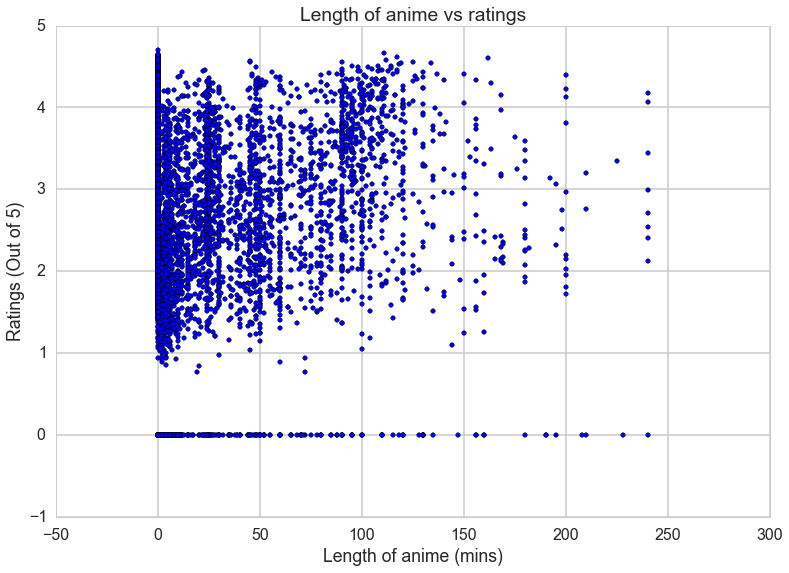

In [35]:
# zoom more into data with lower tlength values
temp_subd1=subd_length[subd_length["tlength"]<250]
plt.scatter(temp_subd1["tlength"], temp_subd1["ratings"])
plt.title("Length of anime vs ratings")
plt.xlabel("Length of anime (mins)")
plt.ylabel("Ratings (Out of 5)")

In [36]:
# Tlength vs rankings
subd_length_rank=pd.DataFrame(data["tlength"], data.index.values)
subd_length_rank["rankings"]=data["rank"]
subd_length_rank

,tlength,rankings
(Making of) Evangelion: Another Impact,6,5996
+A-Channel,22,2398
.hack//G.U. Returner,0,2504
.hack//G.U. Trilogy,93,1576
.hack//G.U. Trilogy Parody,6,3993
.hack//GIFT,0,4108
.hack//LIMINALITY,0,3073
.hack//Legend Of The Twilight,0,3039
.hack//Quantum,0,974
.hack//Quantum Specials,9,3441


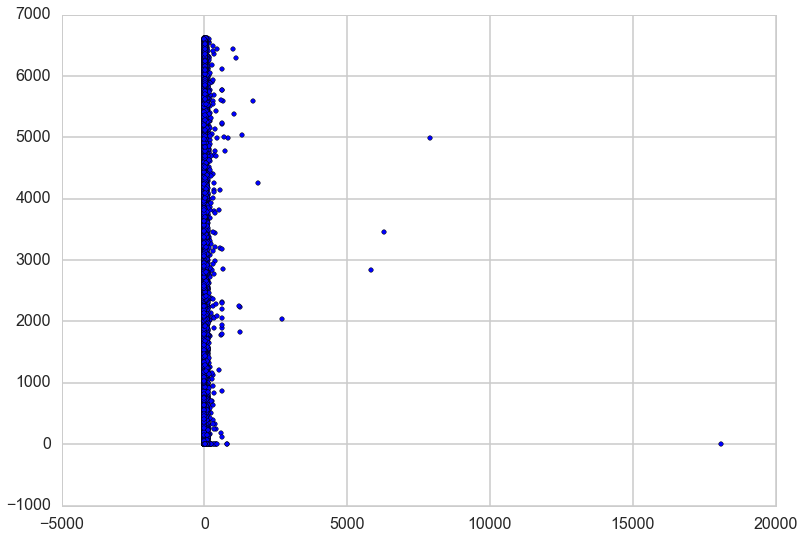

In [37]:
plt.scatter(subd_length_rank["tlength"], subd_length_rank["rankings"])

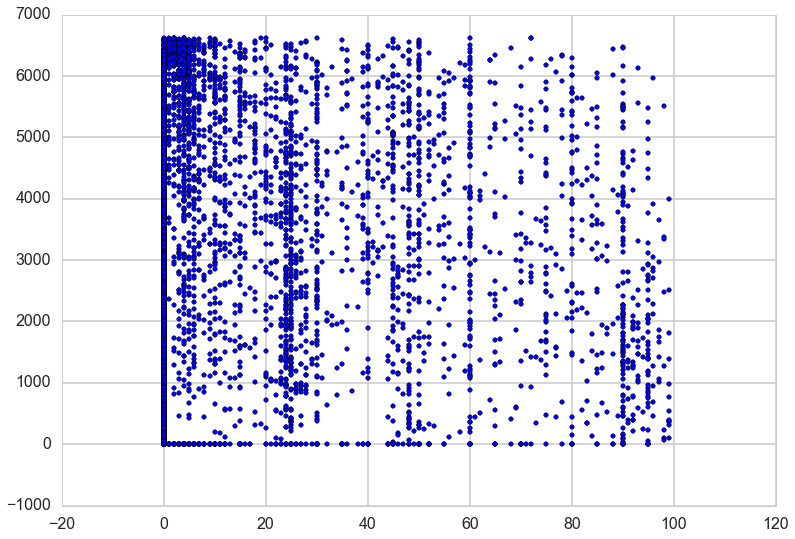

In [38]:
# zoom more into data with lower tlength values
temp_subdl=subd_length_rank[subd_length_rank["tlength"]<100]
plt.scatter(temp_subdl["tlength"], temp_subdl["rankings"])

In [39]:
# episodes vs rankings
subd_ep_rank=pd.DataFrame(data["eps"], data.index.values)
subd_ep_rank["rankings"]=data["rank"]
subd_ep_rank.head(5)

,eps,rankings
(Making of) Evangelion: Another Impact,1,5996
+A-Channel,11,2398
.hack//G.U. Returner,1,2504
.hack//G.U. Trilogy,1,1576
.hack//G.U. Trilogy Parody,1,3993


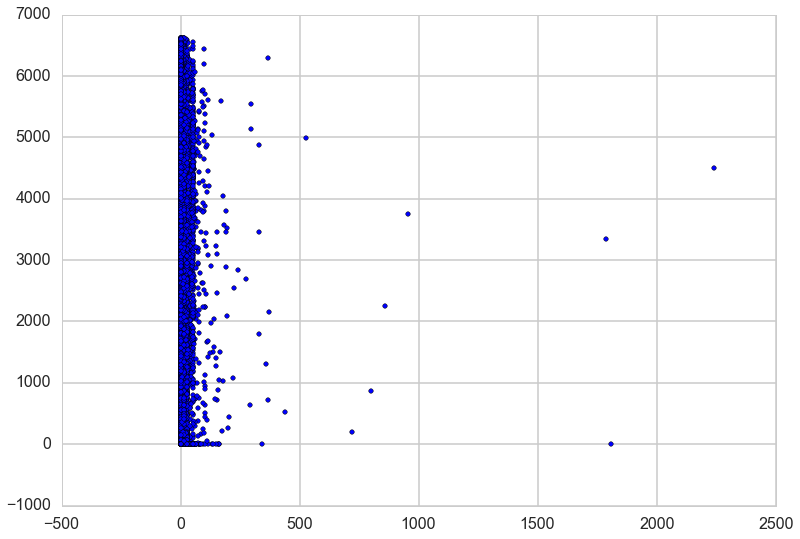

In [40]:
plt.scatter(subd_ep_rank['eps'],subd_ep_rank['rankings'])

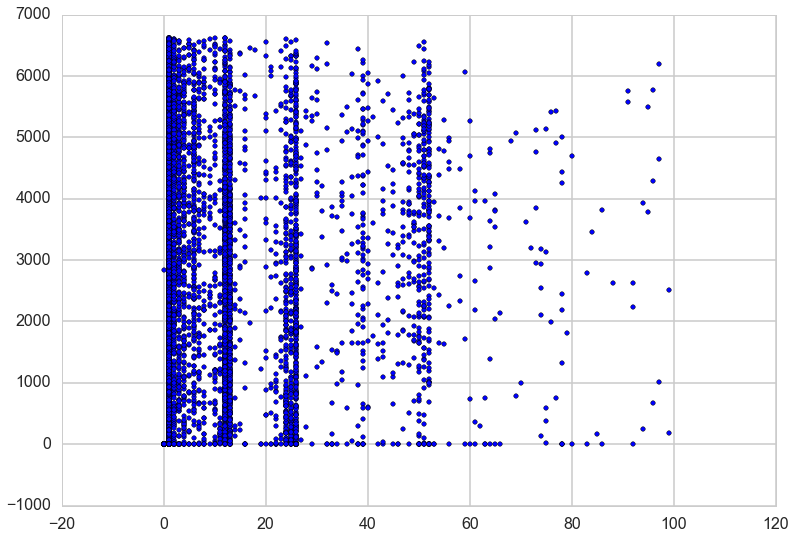

In [41]:
temp_subdep=subd_ep_rank[subd_ep_rank['eps']<100]
plt.scatter(temp_subdep['eps'], temp_subdep['rankings'])

Step 8: 
    1. Scatter episodes and ratings to find any correlation
    2. Scatter episodes and rankings to find any correlation
    3. Observe and record any correlation

In [42]:
# episodes vs ratings
subd_ep_rating=pd.DataFrame(data["eps"], data.index.values)
subd_ep_rating["ratings"]=data["ratings"]
subd_ep_rating.head(5)

,eps,ratings
(Making of) Evangelion: Another Impact,1,1.743
+A-Channel,11,3.334
.hack//G.U. Returner,1,3.291
.hack//G.U. Trilogy,1,3.671
.hack//G.U. Trilogy Parody,1,2.691


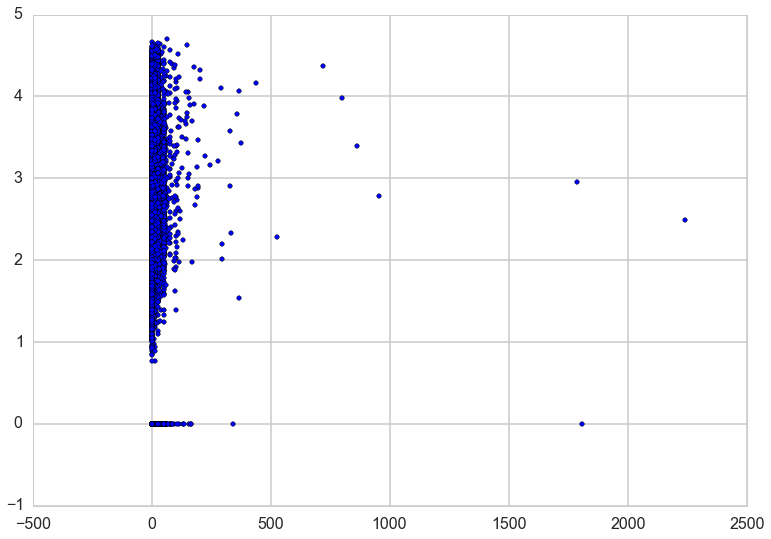

In [43]:
plt.scatter(subd_ep_rating['eps'],subd_ep_rating['ratings'])

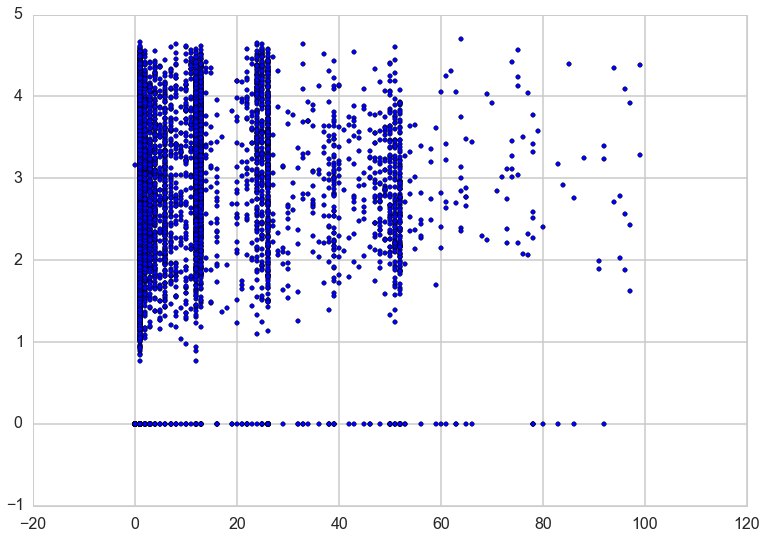

In [44]:
temp_subdep1=subd_ep_rating[subd_ep_rating['eps']<100]
plt.scatter(temp_subdep1['eps'], temp_subdep1['ratings'])

Step 9: 
    1. Scatter votes and ratings to find any correlation
    2. Scatter votes and rankings to find any correlation
    3. Observe and record any correlation

In [45]:
# Votes vs ratings
subd_v_rating=pd.DataFrame(data["votes"], data.index.values)
subd_v_rating["ratings"]=data["ratings"]
subd_v_rating.head(5)

,votes,ratings
(Making of) Evangelion: Another Impact,153,1.743
+A-Channel,1192,3.334
.hack//G.U. Returner,2021,3.291
.hack//G.U. Trilogy,2814,3.671
.hack//G.U. Trilogy Parody,714,2.691


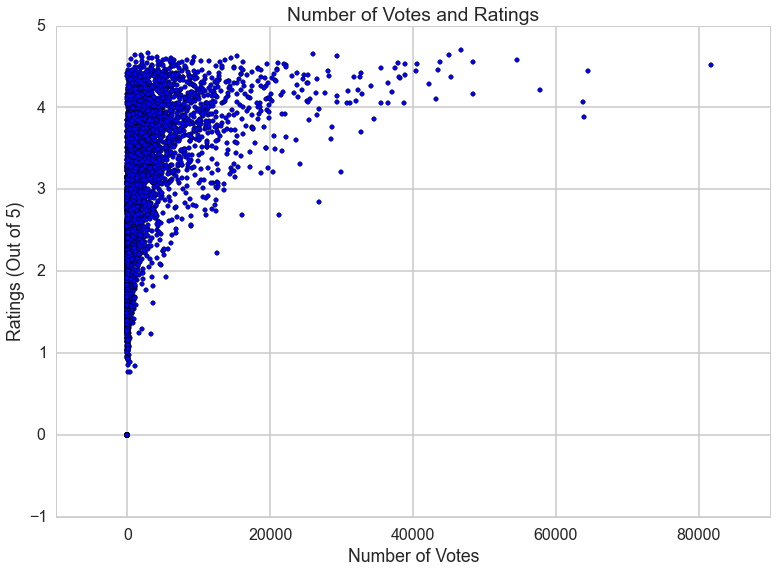

In [46]:
plt.scatter(subd_v_rating["votes"], subd_v_rating["ratings"])
plt.title("Number of Votes and Ratings")
plt.xlabel("Number of Votes")
plt.ylabel("Ratings (Out of 5)")

In [47]:
# Votes s rankings
subd_v_rank=pd.DataFrame(data["votes"], data.index.values)
subd_v_rank["rankings"]=data["rank"]
subd_v_rank.head(5)

,votes,rankings
(Making of) Evangelion: Another Impact,153,5996
+A-Channel,1192,2398
.hack//G.U. Returner,2021,2504
.hack//G.U. Trilogy,2814,1576
.hack//G.U. Trilogy Parody,714,3993


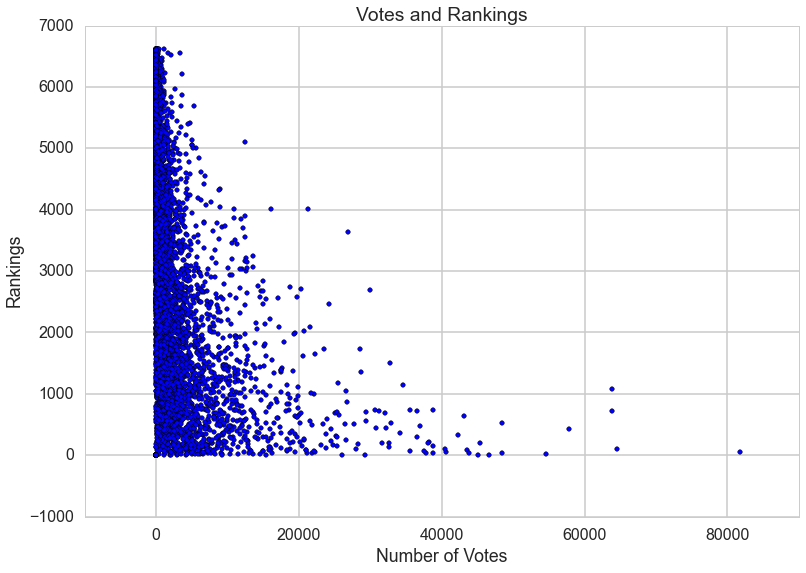

In [48]:
plt.scatter(subd_v_rank["votes"], subd_v_rank["rankings"])
plt.title("Votes and Rankings")
plt.xlabel("Number of Votes")
plt.ylabel("Rankings")

Step 10: 
    1. Scatter date_pub and ratings to find any correlation
    2. Scatter date_pub and rankings to find any correlation
    3. Observe and record any correlation

In [49]:
# Date_pub vs ratings and rankings
subd_dp=pd.DataFrame(data["date_pub"], data.index.values)
subd_dp["rankings"]=data["rank"]
subd_dp["ratings"]=data["ratings"]
subd_dp.head(5)

,date_pub,rankings,ratings
(Making of) Evangelion: Another Impact,2015,5996,1.743
+A-Channel,2011,2398,3.334
.hack//G.U. Returner,2007,2504,3.291
.hack//G.U. Trilogy,2008,1576,3.671
.hack//G.U. Trilogy Parody,2008,3993,2.691


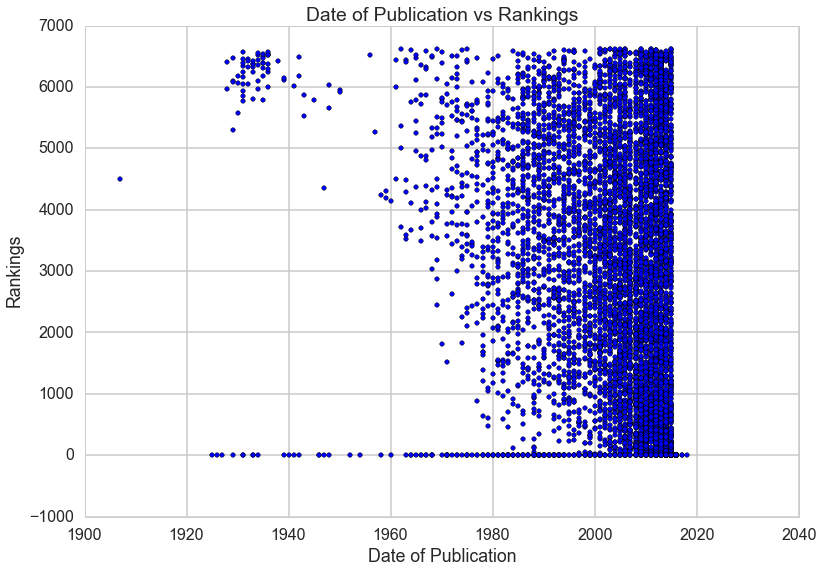

In [50]:
# date_pub vs rankings
plt.scatter(subd_dp["date_pub"], subd_dp["rankings"])
plt.title("Date of Publication vs Rankings")
plt.xlabel("Date of Publication")
plt.ylabel("Rankings")

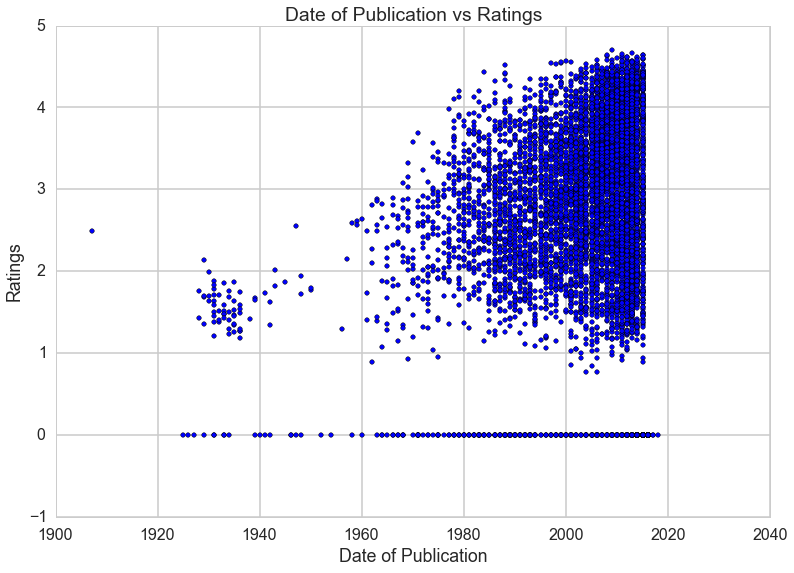

In [51]:
plt.scatter(subd_dp["date_pub"], subd_dp["ratings"])
plt.title("Date of Publication vs Ratings")
plt.xlabel("Date of Publication")
plt.ylabel("Ratings")

Step 11: 
    1. Groupby categories, calculate frequency of categories
    2. Groupby categories, calculate average ratings, sort in descending order
    3. Groupby categories, calculate average rankings, sort in descending order
    4. Observe and record any correlation among Top 10 categories by frequency, average ratings, average rankings

In [52]:
# get categories list
cats=[]
for row in data.index:
    l=data.ix[row,"categories"]
    if type(l)==float:
        l="NA"
    else:
        l=l.replace("[","").replace("]","")
        n=l.split(",")
        for word in n:
            word=word.strip(" ")
            cats.append(word)

In [53]:
c=pd.value_counts(cats, sort=True)
subd_cat=pd.DataFrame(c, c.index.values)
subd_cat.columns=['Frequency']
subd_cat=subd_cat.sort()
subd_cat.head(5)

,Frequency
Abstract,65
Action,1428
Adventure,591
Age Gap,8
Age Transformation,7


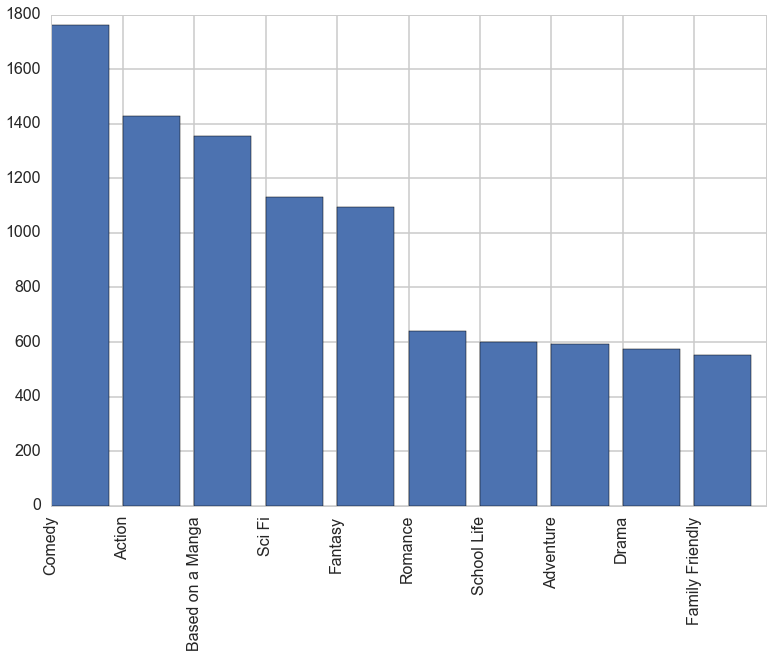

In [54]:
# PLOT TOP 10 CATEGORIES BY FREQUENCY
subd_cat_freq=subd_cat.sort(["Frequency"], ascending=False)
x=np.arange(10)
plt.bar(x,subd_cat_freq.ix[0:10,'Frequency'])
plt.xticks(x, c.index.values[0:10], rotation='vertical')
plt.show()

In [55]:
# categories vs ratings
from collections import defaultdict
cat_rat=defaultdict(int)
for row in data.index:
    l=data.ix[row,"categories"]
    if type(l)==float:
        l="NA"
    else:
        l=l.replace("[","").replace("]","")
        n=l.split(",")
        for word in n:
            word=word.strip(" ")
            cat_rat[word]+=data.ix[row,"ratings"]

In [56]:
subd_cat_rating=pd.DataFrame([cat_rat]).T
subd_cat_rating.columns=['Total Ratings']
subd_cat_rating = subd_cat_rating.sort()
subd_cat_rating["Frequency"]=subd_cat["Frequency"]
subd_cat_rating["Average Ratings"]=subd_cat_rating["Total Ratings"]/subd_cat["Frequency"]
subd_cat_rating = subd_cat_rating.sort(['Average Ratings'], ascending=False)
subd_cat_rating.head(5)

,Total Ratings,Frequency,Average Ratings
Yaoi Hand Syndrome,33.189,8,4.148625
Youkai,4.055,1,4.055000
Age Gap,31.725,8,3.965625
Terrorism,43.020,11,3.910909
Coming of Age,183.670,47,3.907872


In [57]:
# Store categories: Average Ratings in a dictionary
cat_rat_avg=defaultdict(int)
for row in subd_cat_rating.index:
    cat_rat_avg[row]=subd_cat_rating.ix[row,"Average Ratings"]

In [58]:
cat_rat_avg["Coming of Age"]

3.9078723404255329

In [59]:
from collections import defaultdict
cat_rank=defaultdict(int)
for row in data.index:
    l=data.ix[row,"categories"]
    if type(l)==float:
        l="NA"
    else:
        l=l.replace("[","").replace("]","")
        n=l.split(",")
        for word in n:
            word=word.strip(" ")
            cat_rank[word]+=data.ix[row,"rank"]

In [60]:
subd_cat_rank=pd.DataFrame([cat_rank]).T
subd_cat_rank.columns=['Total Rankings']
subd_cat_rank= subd_cat_rank.sort()
subd_cat_rank["Frequency"]=subd_cat["Frequency"]
subd_cat_rank["Average Rankings"]=subd_cat_rank["Total Rankings"]/subd_cat["Frequency"]
subd_cat_rank= subd_cat_rank.sort(['Average Rankings'], ascending=True)
subd_cat_rank.head(5)

,Total Rankings,Frequency,Average Rankings
Yaoi Hand Syndrome,5392,8,674.000000
Youkai,731,1,731.000000
Age Gap,8299,8,1037.375000
Thriller,27355,26,1052.115385
noitaminA,70673,67,1054.820896


In [61]:
cat_rank_avg=defaultdict(int)
for row in subd_cat_rating.index:
    cat_rank_avg[row]=subd_cat_rank.ix[row,"Average Rankings"]

In [62]:
cat_rank_avg["Age Gap"]

1037.375

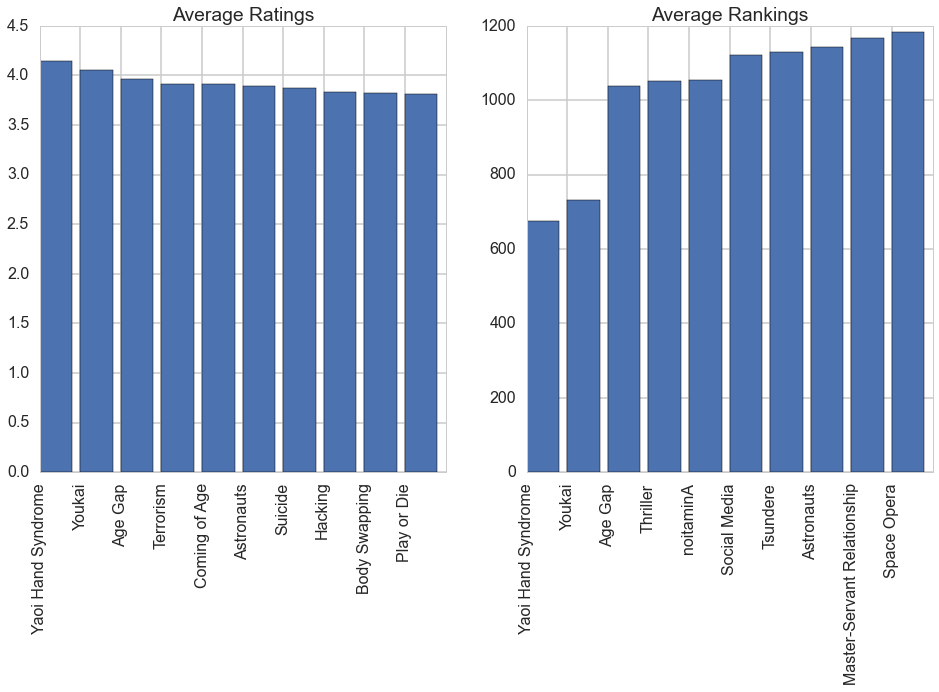

In [63]:
fig, axes= plt.subplots(nrows=1, ncols=2, figsize=(16,8))
x=np.arange(10)
axes[0].bar(x,subd_cat_rating.ix[0:10,'Average Ratings'])
axes[0].set_title('Average Ratings')
axes[0].set_xticks(x)
axes[0].set_xticklabels(subd_cat_rating.index.values[0:10], rotation=90)
axes[1].bar(x,subd_cat_rank.ix[0:10,'Average Rankings'])
axes[1].set_title('Average Rankings')
axes[1].set_xticks(x)
axes[1].set_xticklabels(subd_cat_rank.index.values[0:10], rotation=90)

###Linear Regression Models

Fit linear regression models with all possible predictors, not including number of votes
We don't include number of votes because in the future, we want to make predictions of new release animes that have no ratings or rankings yet to audience and number of votes would have required reviews and ratings from the audience

In [64]:
# Create dataframe with all possible predictors
df=pd.DataFrame(data["rank"], data.index.values)
df["rate"]=data["ratings"]
df["tlength"]= data["tlength"]
df["type"]=data["type"]
df["studio"]=data["studio"]
df["date_pub"]=data["date_pub"]
df["categories"]=data["categories"]
df.head(5)

,rank,rate,tlength,type,studio,date_pub,categories
(Making of) Evangelion: Another Impact,5996,1.743,6,\nWeb,Studio Khara,2015,"[Sci Fi, CG Animation, Japan Animator's Exhibi..."
+A-Channel,2398,3.334,22,\nDVDSpecial,Studio Gokumi,2011,"[Comedy, Slice of Life, Based on a Manga]"
.hack//G.U. Returner,2504,3.291,0,\nOVA,NaN,2007,"[MMORPG, RPG, Virtual Reality]"
.hack//G.U. Trilogy,1576,3.671,93,\nMovie,NaN,2008,"[CG Animation, MMORPG, RPG, Virtual Reality]"
.hack//G.U. Trilogy Parody,3993,2.691,6,\nDVDSpecial,NaN,2008,"[Comedy, MMORPG, RPG, Virtual Reality]"


In [65]:
df = df[df.rate>0]
df = df[df.tlength>0]
df.shape

(3353, 7)

In [66]:
for row in df.index:
    c=data.ix[row,"categories"]
    if type(c)==float:
        df.drop(row, inplace=True)
    else:
        s=data.ix[row,"studio"]
        if type(s)==float:
            df.drop(row, inplace=True)

In [67]:
# fit functions without categories (categories include several different categories and hence would complicate estimations)
import statsmodels.api as sm
from statsmodels.formula.api import glm, ols
ols_model = ols('rank ~ tlength + type +  date_pub', df).fit()
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   rank   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     61.89
Date:                Thu, 10 Dec 2015   Prob (F-statistic):          5.31e-101
Time:                        21:43:43   Log-Likelihood:                -18879.
No. Observations:                2135   AIC:                         3.778e+04
Df Residuals:                    2125   BIC:                         3.783e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Intercept              1.1e+05   7657.881     14.367      0.000       9.5e+04  1.25e+05
type[T.
Movie]       -995.4956    125.311     -7.944      0.000     -1241.241  -749.750
type[T.
MusicVideo]   781.3022    317.834      2.458      0.014       158.003  1404.601
type[T.
OVA]          200.2571    130.216      1.538      0.124       -55.107   455.621
type[T.
Other]        443.5290    207.290      2.140      0.032        37.016   850.042
type[T.
TV]          1490.0640    151.847      9.813      0.000      1192.280  1787.847
type[T.
TVSpecial]   -275.4453    161.074     -1.710      0.087      -591.324    40.433
type[T.
Web]         1624.8993    168.065      9.668      0.000      1295.310  1954.489
tlength                -1.1055      0.176     -6.279      0.000        -1.451    -0.760
date_pub              -53.2334      3.810    -13.973      0.000       -60.705   -45.762
==============================================================================
Omnibus:                      155.934   Durbin-Watson:                   1.566
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               59.591
Skew:                           0.150   Prob(JB):                     1.15e-13
Kurtosis:                       2.239   Cond. No.                     4.23e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.23e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [68]:
# Very low R^2 value, pretty bad model, but somewhat reasonable in realistically 
# Try dropping type, since some coefficients are not statistically significant (p <0.05)
ols_model1 = ols('rank ~ tlength + date_pub', df).fit()
ols_model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   rank   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     20.25
Date:                Thu, 10 Dec 2015   Prob (F-statistic):           1.95e-09
Time:                        21:43:43   Log-Likelihood:                -19108.
No. Observations:                2135   AIC:                         3.822e+04
Df Residuals:                    2132   BIC:                         3.824e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   4.723e+04   7489.567      6.307      0.000      3.25e+04  6.19e+04
tlength       -0.5362      0.187     -2.869      0.004        -0.903    -0.170
date_pub     -21.9153      3.737     -5.864      0.000       -29.245   -14.586
==============================================================================
Omnibus:                     1488.837   Durbin-Watson:                   1.493
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              126.556
Skew:                           0.080   Prob(JB):                     3.30e-28
Kurtosis:                       1.818   Cond. No.                     3.72e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.72e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

R-squared value drops significantly, including type is better. It seems like most predictors are statistically significant but are not enough to explain the variations in rank

Same modeling techniques but this time to predict ratings

In [69]:
ols_model3 = ols('rate ~ tlength + type +  date_pub', df).fit()
ols_model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   rate   R-squared:                       0.209
Model:                            OLS   Adj. R-squared:                  0.206
Method:                 Least Squares   F-statistic:                     62.36
Date:                Thu, 10 Dec 2015   Prob (F-statistic):          1.02e-101
Time:                        21:43:43   Log-Likelihood:                -2387.0
No. Observations:                2135   AIC:                             4794.
Df Residuals:                    2125   BIC:                             4851.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Intercept             -43.3678      3.383    -12.818      0.000       -50.003   -36.733
type[T.
Movie]          0.4385      0.055      7.921      0.000         0.330     0.547
type[T.
MusicVideo]    -0.3191      0.140     -2.272      0.023        -0.594    -0.044
type[T.
OVA]           -0.1011      0.058     -1.757      0.079        -0.214     0.012
type[T.
Other]         -0.1846      0.092     -2.016      0.044        -0.364    -0.005
type[T.
TV]            -0.6669      0.067     -9.941      0.000        -0.798    -0.535
type[T.
TVSpecial]      0.1126      0.071      1.583      0.114        -0.027     0.252
type[T.
Web]           -0.7306      0.074     -9.840      0.000        -0.876    -0.585
tlength                 0.0005   7.78e-05      6.351      0.000         0.000     0.001
date_pub                0.0231      0.002     13.728      0.000         0.020     0.026
==============================================================================
Omnibus:                       74.854   Durbin-Watson:                   1.575
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               48.501
Skew:                          -0.242   Prob(JB):                     2.94e-11
Kurtosis:                       2.443   Cond. No.                     4.23e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.23e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [70]:
ols_model4 = ols('rate ~ tlength + date_pub', df).fit()
ols_model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   rate   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     18.82
Date:                Thu, 10 Dec 2015   Prob (F-statistic):           7.93e-09
Time:                        21:43:43   Log-Likelihood:                -2618.5
No. Observations:                2135   AIC:                             5243.
Df Residuals:                    2132   BIC:                             5260.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    -15.5835      3.314     -4.703      0.000       -22.082    -9.085
tlength        0.0002   8.27e-05      2.902      0.004      7.78e-05     0.000
date_pub       0.0092      0.002      5.591      0.000         0.006     0.012
==============================================================================
Omnibus:                      282.006   Durbin-Watson:                   1.502
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               81.912
Skew:                          -0.181   Prob(JB):                     1.63e-18
Kurtosis:                       2.112   Cond. No.                     3.72e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.72e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Low R-squared value in model 3

R-squared value drops significantly, including type is better. It seems like most predictors are statistically significant but are not enough to explain the variations in rank

###Time Interval Models

In [71]:
years=[
    (1930,1940),
    (1940,1950),
    (1950,1960),
    (1960,1970),
    (1970,1980),
    (1980,1990),
    (1990,2000),
    (2000,2010),
    (2010,2020)]

In [72]:
dict_y=dict()
for year in years:
    temp_df=df[(df.date_pub>=year[0]) & (df.date_pub<=year[1])]
    dict_y[year]=temp_df

In [73]:
dict_y[(1990,2000)]

,rank,rate,tlength,type,studio,date_pub,categories
1+2=Paradise,6187,1.623,60,\nOVA,J.C.Staff,1990,"[Comedy, Ecchi, Based on a Manga, Gynophobia, ..."
1001 Nights,4719,2.395,24,\nMovie,Mushi Pro,1998,"[Fantasy, Romance, Abstract, Original Work]"
2112: The Birth of Doraemon,4263,2.582,31,\nMovie,Shinei Animation,1995,"[Based on a Manga, Family Friendly]"
3 x 3 Eyes,2994,3.095,120,\nOVA,Toei Animation,1991,"[Action, Fantasy, Seinen, Based on a Manga, De..."
8 Man After,4677,2.413,100,\nOVA,J.C.Staff,1993,"[Action, Sci Fi, Based on a Manga, Cyborgs, Po..."
A Wind Named Amnesia,3492,2.895,80,\nMovie,MADHOUSE,1990,"[Sci Fi, Based on a Light Novel, Post-apocalyp..."
Abashiri Family,5724,1.903,80,\nOVA,Studio Pierrot,1991,"[Action, Comedy, Ecchi, Based on a Manga, Hand..."
Adachigahara,5190,2.178,25,\nMovie,Tezuka Productions,1991,[Based on a Manga]
"Adventures of Mini-Goddess, The",4143,2.633,336,\nTV,OLM,1998,"[Comedy, Fantasy, Based on a Manga, Chibi, Magic]"
Agent Aika: Special Trial,5661,1.942,10,\nDVDSpecial,Studio Fantasia,1998,"[Action, Comedy, Ecchi, Sci Fi, Original Work,..."


In [74]:
dict_f=dict()
r2=[]
nrow=[]
for year in years:
    if (dict_y[year].shape[0]>1):
        temp_df=dict_y[year]
        ols_model2 = ols('rank ~ tlength + type + date_pub', temp_df).fit()
        dict_f[year]=ols_model2
        r2.append(ols_model2.rsquared)
        nrow.append(dict_y[year].shape[0])

In [75]:
subd_fit=pd.DataFrame(r2,dict_f.keys())
subd_fit.columns=["R-squared"]
subd_fit['nrow']=nrow
subd_fit=subd_fit.sort()
subd_fit

,R-squared,nrow
"(1950, 1960)",0.254418,20
"(1960, 1970)",0.707574,5
"(1970, 1980)",0.299553,831
"(1980, 1990)",0.140198,850
"(1990, 2000)",0.240956,57
"(2000, 2010)",0.282402,335
"(2010, 2020)",0.222452,234


There doesn't seem to be significant improvement, the higher R-squared is due to the smaller amount of data, which means there is less variation.

In [76]:
# fitting ratings based on predictors

dict_f1=dict()
r2_1=[]
nrow_1=[]
for year in years:
    if (dict_y[year].shape[0]>1):
        temp_df=dict_y[year]
        ols_model2 = ols('rate ~ tlength + type + date_pub', temp_df).fit()
        dict_f1[year]=ols_model2
        r2_1.append(ols_model2.rsquared)
        nrow_1.append(dict_y[year].shape[0])

In [77]:
subd_fit_rat=pd.DataFrame(r2_1,dict_f1.keys())
subd_fit_rat.columns=["R-squared"]
subd_fit_rat['nrow']=nrow_1
subd_fit_rat=subd_fit_rat.sort()
subd_fit_rat

,R-squared,nrow
"(1950, 1960)",0.319132,20
"(1960, 1970)",0.706471,5
"(1970, 1980)",0.303069,831
"(1980, 1990)",0.142938,850
"(1990, 2000)",0.248345,57
"(2000, 2010)",0.281189,335
"(2010, 2020)",0.215399,234


Similarly, higher R-squared here is simply due to less variation.

###Categorical Models

In [78]:
def categories_list(s):
    if type(s) == float:
        return []
    else:
        return s.translate(None, "[]").split(', ')

In [79]:
l = []
for a in data.categories:
    l.append(categories_list(a))
data['categories_list'] = l
categories = set()
for anime in data.categories_list:
        categories.update(i for i in anime)
categories = list(categories)
categories.sort()

In [80]:
for c in categories:
    data[c] = [c in anime for anime in data.categories_list]

In [81]:
# Calculate new ratings based on average of movies'categories' averages 
mov_cat=defaultdict(int)
mov_cat_count=defaultdict(int)
mov_cat_rate=defaultdict(int)

for row in data.index:
    l=data.ix[row,"categories"]
    if type(l)==float:
        mov_cat[row]+= 0
    else:
        l=l.replace("[","").replace("]","")
        n=l.split(", ")
        for word in n:
            mov_cat[row] += cat_rat_avg[word]
            mov_cat_count[row] +=1 #only count when there's a rating

In [82]:
# Calculate a "score" for categories' combinations
for row in data.index:
    if(mov_cat_count[row]>0):
        mov_cat_rate[row]=mov_cat[row]/mov_cat_count[row]
    else:
        mov_cat_rate[row]=0
subd_cat_rate=pd.DataFrame([mov_cat_rate]).T
subd_cat_rate.columns=["Average Ratings"]
subd_cat_rate.head(5)

,Average Ratings
(Making of) Evangelion: Another Impact,2.358749
+A-Channel,2.951899
.hack//G.U. Returner,3.060812
.hack//G.U. Trilogy,2.825134
.hack//G.U. Trilogy Parody,3.019492


In [83]:
df["Cat_Rate"]=subd_cat_rate["Average Ratings"]
df.head(3)

,rank,rate,tlength,type,studio,date_pub,categories,Cat_Rate
(Making of) Evangelion: Another Impact,5996,1.743,6,\nWeb,Studio Khara,2015,"[Sci Fi, CG Animation, Japan Animator's Exhibi...",2.358749
+A-Channel,2398,3.334,22,\nDVDSpecial,Studio Gokumi,2011,"[Comedy, Slice of Life, Based on a Manga]",2.951899
.hack//Roots,2198,3.414,624,\nTV,BEE TRAIN,2006,"[MMORPG, RPG, Virtual Reality]",3.060812


In [84]:
ols_model_cat = ols('rate ~ tlength + type +  date_pub + Cat_Rate', df).fit()
ols_model_cat.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   rate   R-squared:                       0.324
Model:                            OLS   Adj. R-squared:                  0.321
Method:                 Least Squares   F-statistic:                     102.0
Date:                Thu, 10 Dec 2015   Prob (F-statistic):          8.49e-173
Time:                        21:48:49   Log-Likelihood:                -2218.6
No. Observations:                2135   AIC:                             4459.
Df Residuals:                    2124   BIC:                             4522.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Intercept             -40.4003      3.131    -12.902      0.000       -46.541   -34.260
type[T.
Movie]          0.4036      0.051      7.881      0.000         0.303     0.504
type[T.
MusicVideo]    -0.1931      0.130     -1.486      0.138        -0.448     0.062
type[T.
OVA]           -0.1649      0.053     -3.094      0.002        -0.269    -0.060
type[T.
Other]          0.0359      0.085      0.420      0.675        -0.132     0.203
type[T.
TV]            -0.5792      0.062     -9.314      0.000        -0.701    -0.457
type[T.
TVSpecial]      0.0361      0.066      0.548      0.584        -0.093     0.165
type[T.
Web]           -0.3875      0.071     -5.460      0.000        -0.527    -0.248
tlength                 0.0004   7.22e-05      5.238      0.000         0.000     0.001
date_pub                0.0201      0.002     12.853      0.000         0.017     0.023
Cat_Rate                1.0562      0.055     19.050      0.000         0.948     1.165
==============================================================================
Omnibus:                       28.831   Durbin-Watson:                   1.628
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.172
Skew:                          -0.224   Prob(JB):                     2.07e-06
Kurtosis:                       2.693   Cond. No.                     4.23e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.23e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

R-square improves to ~0.3. This model, including a "score" for categories, explains the variations in rate better!

In [85]:
# Calculate new rankings based on average of movies'categories' averages 
mov_catr=defaultdict(int)
mov_cat_countr=defaultdict(int)
for row in data.index:
    l=data.ix[row,"categories"]
    if type(l)==float:
        mov_catr[row]+= 0
    else:
        l=l.replace("[","").replace("]","")
        n=l.split(", ")
        for word in n:
            mov_catr[row] += cat_rank_avg[word]
            mov_cat_countr[row] +=1 #only count when there's a rating

In [86]:
# Calculate a "score" for categories' combinations
mov_cat_rank=defaultdict(int)
for row in data.index:
    if(mov_cat_count[row]>0):
        mov_cat_rank[row]=mov_catr[row]/mov_cat_countr[row]
    else:
        mov_cat_rank[row]=0
subd_cat_rank=pd.DataFrame([mov_cat_rank]).T
subd_cat_rank.columns=["Average Rankings"]
subd_cat_rank.head(5)

,Average Rankings
(Making of) Evangelion: Another Impact,3660.255642
+A-Channel,2447.754744
.hack//G.U. Returner,2243.165852
.hack//G.U. Trilogy,2509.070222
.hack//G.U. Trilogy Parody,2355.008753


In [87]:
df["Cat_Rank"]=subd_cat_rank["Average Rankings"]
df.head(3)

,rank,rate,tlength,type,studio,date_pub,categories,Cat_Rate,Cat_Rank
(Making of) Evangelion: Another Impact,5996,1.743,6,\nWeb,Studio Khara,2015,"[Sci Fi, CG Animation, Japan Animator's Exhibi...",2.358749,3660.255642
+A-Channel,2398,3.334,22,\nDVDSpecial,Studio Gokumi,2011,"[Comedy, Slice of Life, Based on a Manga]",2.951899,2447.754744
.hack//Roots,2198,3.414,624,\nTV,BEE TRAIN,2006,"[MMORPG, RPG, Virtual Reality]",3.060812,2243.165852


In [88]:
ols_model_cat_rank = ols('rank ~ tlength + type +  date_pub + Cat_Rank', df).fit()
ols_model_cat_rank.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   rank   R-squared:                       0.320
Model:                            OLS   Adj. R-squared:                  0.317
Method:                 Least Squares   F-statistic:                     100.2
Date:                Thu, 10 Dec 2015   Prob (F-statistic):          3.61e-170
Time:                        21:48:49   Log-Likelihood:                -18715.
No. Observations:                2135   AIC:                         3.745e+04
Df Residuals:                    2124   BIC:                         3.751e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Intercept            8.891e+04   7182.133     12.379      0.000      7.48e+04  1.03e+05
type[T.
Movie]       -786.7504    116.608     -6.747      0.000     -1015.428  -558.073
type[T.
MusicVideo]   512.5637    294.760      1.739      0.082       -65.486  1090.613
type[T.
OVA]          403.3781    121.105      3.331      0.001       165.882   640.874
type[T.
Other]         66.5552    193.062      0.345      0.730      -312.054   445.165
type[T.
TV]          1523.1235    140.668     10.828      0.000      1247.262  1798.985
type[T.
TVSpecial]    -29.6271    149.777     -0.198      0.843      -323.353   264.099
type[T.
Web]          938.7728    159.912      5.871      0.000       625.173  1252.372
tlength                -0.9150      0.163     -5.600      0.000        -1.236    -0.595
date_pub              -44.4806      3.560    -12.495      0.000       -51.462   -37.500
Cat_Rank                1.2448      0.066     18.776      0.000         1.115     1.375
==============================================================================
Omnibus:                       49.492   Durbin-Watson:                   1.606
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.035
Skew:                           0.153   Prob(JB):                     1.82e-07
Kurtosis:                       2.494   Cond. No.                     7.42e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.42e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [89]:
# Try include all variables to predict rankings
ols_model_fullrank = ols('rank ~ tlength + type +  date_pub + Cat_Rank + Cat_Rate + rate', df).fit()
ols_model_fullrank.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   rank   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                 2.850e+04
Date:                Thu, 10 Dec 2015   Prob (F-statistic):               0.00
Time:                        21:48:50   Log-Likelihood:                -13695.
No. Observations:                2135   AIC:                         2.742e+04
Df Residuals:                    2122   BIC:                         2.749e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Intercept            1.209e+04    717.998     16.834      0.000      1.07e+04  1.35e+04
type[T.
Movie]         -5.3920     11.308     -0.477      0.634       -27.568    16.784
type[T.
MusicVideo]    60.1792     28.108      2.141      0.032         5.056   115.302
type[T.
OVA]          -24.7689     11.579     -2.139      0.033       -47.476    -2.062
type[T.
Other]         24.4671     18.479      1.324      0.186       -11.772    60.706
type[T.
TV]            -9.7226     13.929     -0.698      0.485       -37.038    17.593
type[T.
TVSpecial]    -18.7827     14.282     -1.315      0.189       -46.791     9.225
type[T.
Web]          -26.9266     15.446     -1.743      0.081       -57.217     3.364
tlength                 0.0082      0.016      0.524      0.600        -0.023     0.039
date_pub               -1.1096      0.352     -3.156      0.002        -1.799    -0.420
Cat_Rank                0.0202      0.013      1.517      0.129        -0.006     0.046
Cat_Rate               12.3838     25.349      0.489      0.625       -37.329    62.096
rate                -2251.1268      4.709   -478.078      0.000     -2260.361 -2241.893
==============================================================================
Omnibus:                     1438.327   Durbin-Watson:                   1.862
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            37405.623
Skew:                          -2.786   Prob(JB):                         0.00
Kurtosis:                      22.734   Cond. No.                     7.78e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.78e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

If we include rate into rank equation, R^2 shoots up significantly to 0.894. However, realistically, we can't really know rate for new release anime right after it is released so we would have less information to predict the ranking.

In [90]:
# Try include all variables to predict rankings/ratings
ols_model_fullrate = ols('rate ~ tlength + type +  date_pub + Cat_Rank + Cat_Rate + rank', df).fit()
ols_model_fullrate.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   rate   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                 2.850e+04
Date:                Thu, 10 Dec 2015   Prob (F-statistic):               0.00
Time:                        21:48:50   Log-Likelihood:                 2795.0
No. Observations:                2135   AIC:                            -5564.
Df Residuals:                    2122   BIC:                            -5490.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Intercept               4.9767      0.320     15.538      0.000         4.349     5.605
type[T.
Movie]          0.0011      0.005      0.216      0.829        -0.009     0.011
type[T.
MusicVideo]     0.0248      0.012      1.991      0.047         0.000     0.049
type[T.
OVA]           -0.0126      0.005     -2.455      0.014        -0.023    -0.003
type[T.
Other]          0.0110      0.008      1.346      0.179        -0.005     0.027
type[T.
TV]            -0.0100      0.006     -1.623      0.105        -0.022     0.002
type[T.
TVSpecial]     -0.0081      0.006     -1.284      0.199        -0.020     0.004
type[T.
Web]           -0.0154      0.007     -2.255      0.024        -0.029    -0.002
tlength              7.169e-06   6.94e-06      1.032      0.302     -6.45e-06  2.08e-05
date_pub               -0.0003      0.000     -1.983      0.047        -0.001 -3.42e-06
Cat_Rank             6.588e-06   5.89e-06      1.118      0.264     -4.97e-06  1.81e-05
Cat_Rate                0.0113      0.011      1.010      0.313        -0.011     0.033
rank                   -0.0004   9.21e-07   -478.078      0.000        -0.000    -0.000
==============================================================================
Omnibus:                     1545.625   Durbin-Watson:                   1.868
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            46070.293
Skew:                          -3.053   Prob(JB):                         0.00
Kurtosis:                      24.923   Cond. No.                     1.13e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

###Summary

DATA EXPLORATORY:

Studios:
-	Strong correlation between frequency and average ratings: higher frequency (number of studios that anime come from, higher the ratings) -> can also indicate bias that studios produce better movies are more popular, produce more popular animes, and hence have more ratings since the animes are more well-known
-	Much greater variation in frequency compared to differences among average ratings among animes
-	No correlation between ratings and rankings. The top 10 rankings don’t overlap with top 10 ratings generally

Types: 
-	Same as studios but there’s strong correlation between average ratings and rankings. The lists are exactly the same in the same order. 

Tlengths:
-	Most movies tends to have length of less than 100 minutes in total- cluster toward lower lengths, with some outliers
-	No systematic correlation between tlengths and ratings/rankings

Episodes:
-	Most movies have under 50 episodes, with lots of clusters around 1 episode, 15-20 episodes, 20-25 episodes, and 50-55 episodes
-	No systematic correlation with ratings and rankings

Votes:
-	More votes -> higher ratings -> lower ranks (higher place) 
-	Votes and ratings/rankings are curve graphs

Date_pub:
-	Small clusters around 1930s -> lots of animes in this period have very high ranks (bad ranking)
-	But closer to the recent dates tend to generally have a bit better rankings (low ranks) but pretty random

Categories:
-	Some overlapping between ratings and rankings (esp for top ratings ones and top ranks) but less later in top 10
-	Frequency doesn’t correlate with ratings and rankings at all – VERY DIFFERENT LISTS

FITTING MODELS:

-   R^2/Adjusted R^2 value is so small, yet all the predictors seem to be statistically significant. Perhaps this suggests that we don't have enough predictors to explain variations in ranks and ratings.
-   Cluster data based on decades/time intervals don't significantly improve the data much
-   Include a score to quanitfy combination of categories help improve R^2/Adjusted R^2
-   Include rank to predict rate and include rate to predict rank help increase R^2 and adjusted R^2 dramatically

#Data Analysis

##Recommender Systems

In [2]:
final = pd.read_csv('../data/final_review.csv',index_col=0)
final.head()

,anime,anime_name,name,age,sex,reviews,overall,animation,character,sound,story,Trains,BoardingHouse,Political,Demons,BasedonaLightNovel,Supernatural,Comedy,BountyHunters,Harem,EmotionalAbuse,Androids,Robots,Mecha,Western,Ninja,Thriller,Adventure,LoveTriangle,Magic,RPG,Violence,Shinigami,Military,Sports,Parody,TimeTravel,Aliens,JapaneseMythology,ReverseHarem,Cyberpunk,Swordplay,ClassicalMusic,Detectives,FeudalJapan,Romance,Terrorism,Tournaments,MagicalGirl,PantyShots,...,BasedonaVideoGame,Mercenaries,PersoninaStrangeWorld,FoodandBeverage,Vampires,Cyborgs,Incest,Shoujo-ai,MMORPG,LGBTThemes,noitaminA,Abstract,SuddenGirlfriendAppearance,Monster-of-the-week,Mystery,OriginalWork,Police,WorkLife,PsychicPowers,Maids,PlayorDie,Chibi,Dystopia,Psychological,HandtoHandCombat,Crude,Angels,SliceofLife,BasedonaVisualNovel,ExplicitSex,Shorts,Survival,OuterSpace,CGAnimation,Master-ServantRelationship,ExplicitViolence,Assassins,MatureThemes,Josei,MartialArts,America,BasedonanOtomeGame,Gunfights,Samurai,ComingofAge,AnimalAbuse,Fantasy,PhysicalAbuse,SchoolLife,Ecchi
0,to-aru-majutsu-no-index-10th-anniversary-pv,To Aru Majutsu no Index 10th Anniversary PV,SogiitaGunhaGUTS,15.00000,M,Well it's a short animation to celebrate Kamac...,10,10,10,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,dokkoida,Dokkoida?!,angelsreviews,26.00000,F,NaN,5,5,6,5,8,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,inazuma-eleven,Inazuma Eleven,xxjacobxx3,25.00000,M,first of all: I agree with ﻿﻿﻿﻿luminex's revie...,9,9,9,9,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,inazuma-eleven,Inazuma Eleven,Lumineux,25.23511,F,Story: 6,7,8,6,8,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,brigadoon-marin-to-melan,Brigadoon Marin to Melan,roriconfan,34.00000,M,NaN,8,8,8,9,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


There are six main components to the dataframe, with each row corresponding to a review.  They are:

* `anime`: both *anime* and *anime_name* reference the title of the anime being reviewed
* `name`: the user id who made the review
* `age/sex`: information about the user
* `reviews`: text review of the anime
* `ratings`: numerical reviews of the anime; five categories: *overall*, *animation*, *character*, *sound*, and *story*; these are rated out of 10
* `categories`: indicator variables for each category

### Missing Data

Working with missing data is a topic of lengthy discussion in the fields of data science, statistics, research, and frankly any field that works with information of any type.  While there is no universally accepted best method of dealing with missing data, here we have implemented one of the most common - replacing the missing entries with the mean of the values from that feature's column.

In [3]:
# fill empty ratings with the average
ratings = ['animation','character','overall','sound','story']
for i in ratings:
    mean = final[i].mean()
    final[i].fillna(mean,inplace=True)

In [4]:
# in case of repeats
final=final.drop_duplicates(['anime','name'])
final.shape

(17194, 141)

###Baseline Predictions

In order for any predictive model to make accurate predictions, you need data of the right form.  If a lot of people who review Anime A well also review Anime B well, then the model should be able to make that connection fairly easily.  On the other hand, if an anime doesn't have very many reviews, or the people who reviewed it didn't review any other anime, it would be difficult to know what's similar and what isn't.

User review counts mean and median 3.85342895563 1.0


(0, 25)

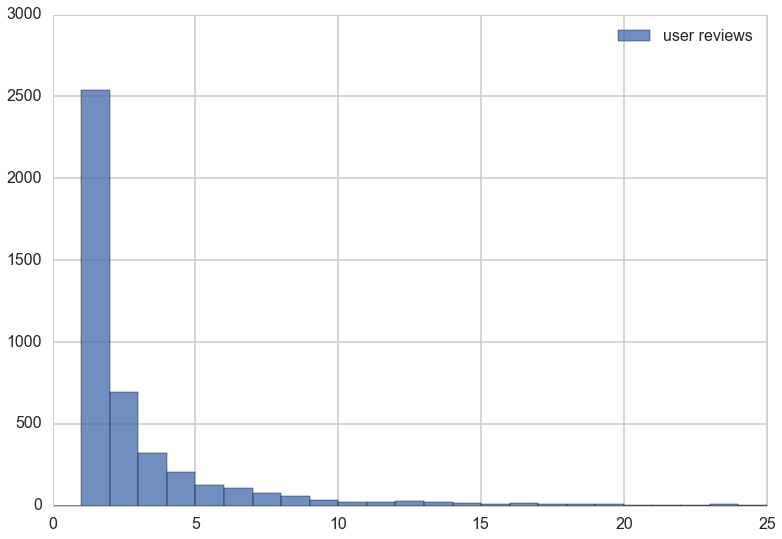

In [5]:
c=final.groupby('name').anime.count()
print "User review counts mean and median",np.mean(c), np.median(c)
plt.hist(c, bins=np.arange(50), alpha=0.8, label="user reviews");
plt.legend();
plt.xlim([0,25])

Unfortunately, it seems like a lot of the users are not very active - the average is ~4 reviews/user, with more than half of them only having one review.  This isn't very conducive to our analysis, due to the common support being necessary to make good predictions.

We split the data into three sets - train, validate, and test. In order to ensure that every anime/user in the validate/test sets are in the training set, we only use those with 3+ reviews/user in test/validate, then filter the sets further to remove those whose business does not appear in the training set.

In [6]:
trainlist=[]
testlist=[]
validatelist=[]
take=2
for k, v in final.groupby('name'):
    if len(v) > 2:
        takenos=np.random.choice(range(take), size=take/2, replace=False)
        takelist=np.array([e in takenos for e in range(take)])
        validatelist.append(v[-take:][~takelist])#use those 
        testlist.append(v[-take:][takelist])#use the other 
        trainlist.append(v[:-take])
    else:
        trainlist.append(v)
traindf=pd.concat(trainlist)
validatedf=pd.concat(validatelist)
testdf=pd.concat(testlist)
print traindf.shape, validatedf.shape, testdf.shape

(14748, 141) (1223, 141) (1223, 141)


In [7]:
# filter missing businesses
train = traindf.append(validatedf[~validatedf.anime.isin(traindf.anime)]).append(testdf[~testdf.anime.isin(traindf.anime)])
validate = validatedf[validatedf.anime.isin(traindf.anime)]
test = testdf[testdf.anime.isin(traindf.anime)]

In [8]:
# double checking that everything in test/validate is represented in training
maskval=[e in set(validate.anime).difference(set(train.anime)) for e in validate.anime] 
masktest=[e in set(test.anime).difference(set(train.anime)) for e in test.anime] 
print np.sum(maskval), np.sum(masktest)

0 0


In [9]:
# mapping of userid and anime
uuids=train.name.unique()#unique-user-ids
uiids=train.anime.unique()#unique-item-ids

uuidmap={v:k for k,v in enumerate(uuids)}#of length U
uiidmap={v:k for k,v in enumerate(uiids)}#of length M

We can begin by looking at a basic predictive model - the baseline model. For each user and business, we can calculate their individual biases.  For example, say the average review overall is around 5, then if your average review is 7, we would assume that you typically rate anime 2 points higher than somebody else would.  So if we calculate all these biases, we can then apply it to other anime to predict what your rating would be.

In [10]:
# append user_avg to final df
m = final[['name','overall']].groupby('name').mean()
m_dict = m.to_dict()['overall']
final['user_avg'] = final.name.map(m_dict)

In [11]:
train_ybar = train.overall.mean()

# calculating biases for user, anime, sex, and age
biases = {}
for cat in ['name', 'anime', 'sex', 'age']:
    # calculate means
    m = train[[cat,'overall']].groupby(cat).mean()
        
    biases[cat] = (m - train_ybar).to_dict()['overall']

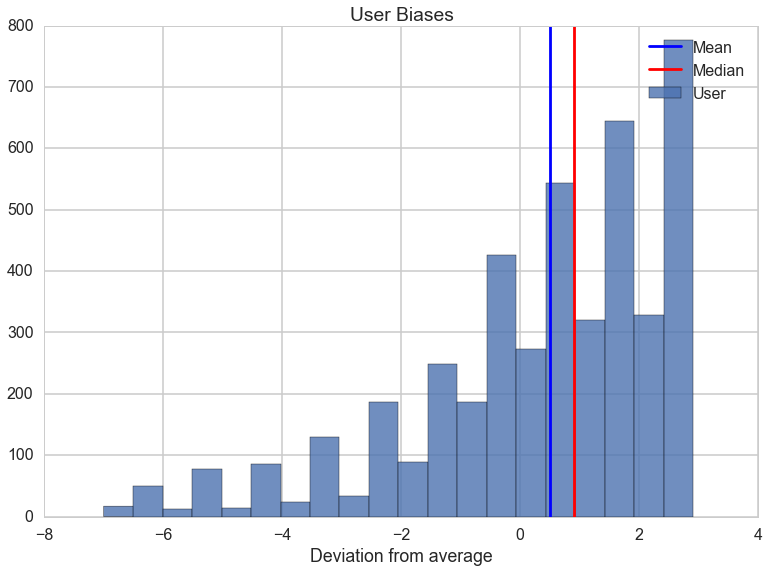

In [12]:
hist1 = plt.hist(biases['name'].values(),alpha=0.8,bins=20,label='User')
plt.title('User Biases')
plt.xlabel("Deviation from average")
plt.axvline(x=np.mean(biases['name'].values()), label='Mean')
plt.axvline(x=np.median(biases['name'].values()), color='r', label='Median')
plt.legend()

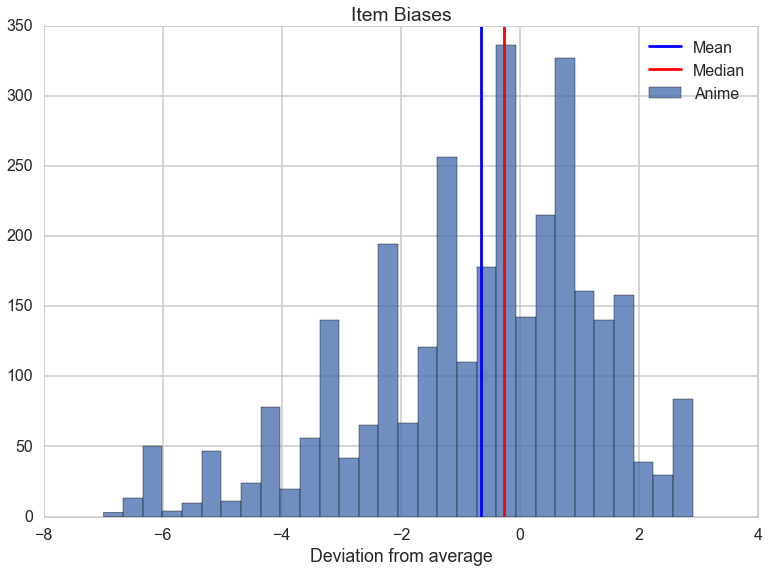

In [13]:
hist2 = plt.hist(biases['anime'].values(),bins=30,alpha=0.8,label='Anime')
plt.title('Item Biases')
plt.xlabel("Deviation from average")
plt.axvline(x=np.mean(biases['anime'].values()), label='Mean')
plt.axvline(x=np.median(biases['anime'].values()), color='r', label='Median')
plt.legend()

The shapes of the two graphs are definitely interesting.  First of all, there are clear peaks at each integer, since users have a tendency to make their ratings whole numbers, even though they were allowed to make them decimals (halves were also not uncommon, such as 5.5, 6.5, etc.).  Secondly, so many users tended to have a positive bias - it's very possible that people will only go through the effort of rating an anime if they particularly enjoyed it, something that's also reflected in the mean rating being around 7-7.5.

In [14]:
predictions={}
predictions_valid={}

In [15]:
# test set
test_ubias = [biases['name'][user] for user in test.name]
test_ibias = [biases['anime'][anime] for anime in test.anime]
predictions["baseline"] = [train_ybar + u + i for u, i in zip(test_ubias, test_ibias)]

In [16]:
# validate set
val_ubias = [biases['name'][user] for user in validate.name]
val_ibias = [biases['anime'][anime] for anime in validate.anime]
predictions_valid["baseline"] = [train_ybar + u + i for u, i in zip(val_ubias, val_ibias)]

In [17]:
def get_rmse(s, s_predict):
    diff = np.subtract(s, s_predict)
    return np.sqrt(np.dot(diff,diff)/diff.shape[0])

In [18]:
def compare_results(stars_actual, stars_predicted, ylow=0, yhigh=10, model="", predicteds=False, onsame=False, axis=False):
    """
    plot predicted results against actual results. Takes 2 arguments: a
    numpy array of actual ratings and a numpy array of predicted ratings
    scatterplots the predictions, a unit slope line, line segments joining the mean,
    and a filled in area of the standard deviations."
    """
    if onsame:
        ax=onsame
    elif axis:
        ax=axis
    else:
        fig=plt.figure()
        ax=plt.gca()
    df=pd.DataFrame(dict(actual=stars_actual, predicted=stars_predicted))
    xp=[]
    yp=[]
    for k,v in df.groupby('actual'):
        xp.append(k)
        yp.append(v.predicted.mean())        
    
    cl, = ax.plot(xp,yp, 's-', label="means for %s" % model)
    c=cl.get_color()

    sig=df.groupby('actual').predicted.std().values
    ax.fill_between(xp, yp - sig, yp + sig, 
                 color=c, alpha=0.2)
    if predicteds:
        ax.plot(df.actual, df.predicted, '.', color=c, alpha=0.1, label="predicted for %s" % model)

    if not onsame:
        ax.plot([0,10],[0,10], 'k', label="slope 1")
        ax.set_xlabel("actual")
        ax.set_ylabel("predicted")
        ax.set_ylim([ylow,yhigh])
        ax.set_xlim([0, 10])
    ax.legend(frameon=False, loc="upper left")
    rmse=get_rmse(stars_actual, stars_predicted)
    print "RMSE for %s" % model, rmse
    return ax,rmse

RMSE for baseline 2.37843372483


/Users/tiffanylee/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


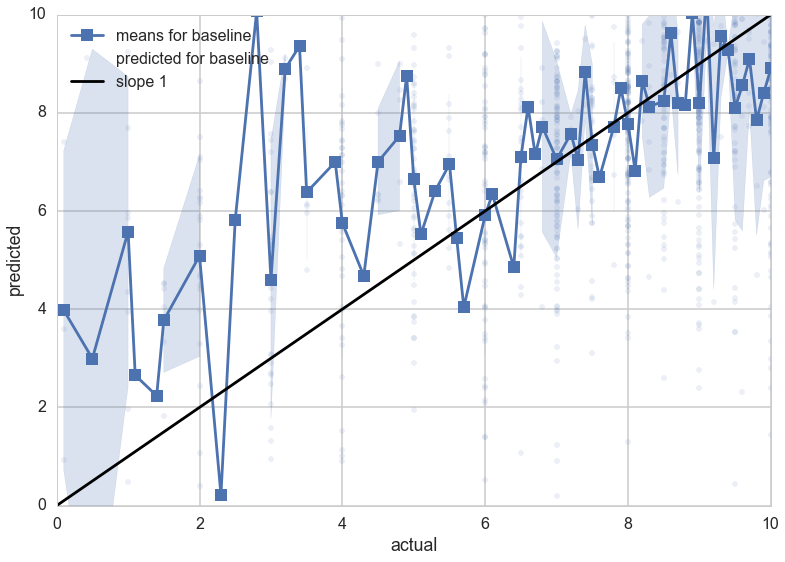

In [19]:
compare_results(test.overall.tolist(),predictions['baseline'], model="baseline", predicteds=True);

While the graph itself here seems to follow the optimal line (slope = 1) fairly well, especially at the higher ratings, the RMSE is still particularly high.  There is a definite possibility that the prediction follows the optimal slope so well is because many users tended to have high ratings, so if you simply predicted an 8, for example, you would already be fairly correct.  This is also fairly evident when you look at how inaccurate the lower ratings are.

###kNN Predictions

While the baseline prediction can give us a general starting point for making predictions, it fails to take into account similarity and many other factors that could be useful in prediction.  That is, if we look at anime that have users in common, those users would probably rate them similarity, and etc.

In [20]:
#for each restaurant get the unique userids who rated it
users_for_anime = train.groupby('anime')['name'].unique()
anime=uiids
lres=len(anime)
supports=[[[] for i in range(lres)] for i in range(lres)]
supporthistlist=[]
for i,an1 in enumerate(anime):
    for j,an2 in enumerate(anime):
        if  i <= j:#its symmetric
            if an1==an2:
                common_reviewers=users_for_anime[an1]
            else:
                common_reviewers = set(users_for_anime[an1]).intersection(set(users_for_anime[an2]))
                supporthistlist.append(len(common_reviewers))
            supports[i][j]=common_reviewers
            supports[j][i]=common_reviewers
print "Mean and Median support is:",np.mean(supporthistlist), np.median(supporthistlist)

Mean and Median support is: 0.104041686179 0.0


Pearson similarity is used to make ratings by two different users more comparable - however, if two users do not have any common anime between them, the value will be zero.

In [21]:
"""
Given a subframe or dictionary of anime 1 reviews and a subframe or dictionary of anime 2 reviews, 
and the number of common reviewers n_common,
where the reviewers are those who have reviewed both anime, return 
the pearson correlation coefficient between the user average subtracted ratings.
The case for zero common reviewers is handled separately, return 0. If the correlation is
NaN if any of the individual variances are 0 (the n=1 case), return 0 instead.
"""
def pearson_sim(rest1_reviews, rest2_reviews, n_common):
    r1 = rest1_reviews['overall'] - rest1_reviews['user_avg']
    r2 = rest2_reviews['overall'] - rest2_reviews['user_avg']
    rho = pearsonr(r1, r2)[0]
    if np.isnan(rho):
        rho = 0
    return rho

In [22]:
def get_anime_reviews(anime, df, set_of_users):
    """
    given a anime and a set of reviewers, return the sub-dataframe of their
    reviews.
    """
    mask = (df.name.isin(set_of_users)) & (df.anime==anime)
    reviews = df[mask]
    reviews = reviews[reviews.name.duplicated()==False]
    return reviews

Next, we must create a database where we look at the user-restaurant pairings and their ratings, and finally calculate their similarities.  This will be used to calculate the k nearest neighbors (which is where the name kNN comes from).

In [23]:
class Database:
    "A class representing a database of similarities and common supports"
    
    def __init__(self, rindexmap, supports):
        "the constructor, takes a map of animes to integers"
        database={}
        self.rindexmap=rindexmap
        self.supports=supports
        l_keys=len(self.rindexmap.keys())
        self.database_sim=np.zeros([l_keys,l_keys])
        self.database_sup=np.zeros([l_keys, l_keys], dtype=np.int)

    def set_supports(self, supports):
        self.supports=supports
        
    def get(self, b1, b2):
        "returns a tuple of similarity,common_support given two animes"
        sim=self.database_sim[self.rindexmap[b1]][self.rindexmap[b2]]
        nsup=self.database_sup[self.rindexmap[b1]][self.rindexmap[b2]]
        return (sim, nsup)

In [24]:
db=Database(uiidmap, supports)

In [25]:
def mapper1(row):
    return row[3], (row[1], row[7], row[-1])

def combiner(items):
    indict={}
    for key, value in items:
        if not indict.has_key(key):
            indict[key]=[]
        indict[key].append(value)
    return indict.items()

def reducer1(the_input):
    name, values = the_input
    ratings=[]
    for anime,overall,user_avg in values:
        ratings.append((anime,(overall, user_avg)))
    return name, ratings

from itertools import combinations_with_replacement

def mapper2(itemstuple):
    combs = combinations_with_replacement(itemstuple[1],2)
    return [((c[0][0],c[1][0]), (c[0][1],c[1][1])) for c in combs]

def combiner_list(itemslist):
    indict={}
    for items in itemslist:
        for key, value in items:
            if not indict.has_key(key):
                indict[key]=[]
            indict[key].append(value)
    return indict.items()

def reducer2(the_input):
    common_ratings = the_input[1]
    n_common = len(common_ratings)
    r1_stars = []
    r1_avg = []
    r2_stars = []
    r2_avg = []
    for rating in common_ratings:
        r1_stars.append(rating[0][0])
        r1_avg.append(rating[0][1])
        r2_stars.append(rating[1][0])
        r2_avg.append(rating[1][1])
    r1_dict = {'overall':np.array(r1_stars),'user_avg':np.array(r1_avg)}
    r2_dict = {'overall':np.array(r2_stars),'user_avg':np.array(r2_avg)}
    rho = pearson_sim(r1_dict,r2_dict,n_common)
    return the_input[0], (rho, n_common)

def map_reduce(tuples):
    mapped1=map(mapper1, tuples)
    combine1=combiner(mapped1)
    reduced1=reduce(lambda x,y: x + [reducer1(y)], combine1, [])
    mapped2=map(mapper2,reduced1)
    combine2=combiner_list(mapped2)
    output=reduce(lambda x,y: x + [reducer2(y)], combine2, [])
    return output

In [28]:
%%time
tuples=train.itertuples()
sims=map_reduce(tuples)

CPU times: user 50min 10s, sys: 2min 33s, total: 52min 44s
Wall time: 54min 16s


In [29]:
def populate_from_mr(db, df, mapredlist):
    for tpair,vpair in mapredlist:
        i1=db.rindexmap[tpair[0]]
        i2=db.rindexmap[tpair[1]]
        db.database_sim[i1][i2]=vpair[0]
        db.database_sup[i1][i2]=vpair[1]
        db.database_sim[i2][i1]=vpair[0]
        db.database_sup[i2][i1]=vpair[1]

In [30]:
populate_from_mr(db, train, sims)

In [31]:
def shrunk_sim(sim, n_common, reg=3.):
    "takes a similarity and shrinks it down by using the regularizer"
    ssim=(n_common*sim)/(n_common+reg)
    return ssim

In [32]:
"""
Function
--------
knearest

Parameters
----------
anime : string
    The name of the anime whose nearest neighbors we want
set_of_animes : array
    The set of animes from which we want to find the nearest neighbors
dbase : instance of Database class.
    A database of similarities, on which the get method can be used to get the similarity
  of two animes. e.g. dbase.get(rid1,rid2)
k : int
    the number of nearest neighbors desired, default 7
reg: float
    the regularization.
    
  
A sorted list
    of the top k similar animes. The list is a list of tuples
    (anime, shrunken <strong>distance</strong>, common support).
"""

from operator import itemgetter
def knearest(anime, set_of_animes, dbase, k=7, reg=3.):
    """
    Given a anime, dataframe, and database, get a sorted list of the
    k most similar animes from the set of anime.
    """
    similars=[]
    for other_anime in set_of_animes:
        if other_anime!=anime:
            sim, nc=dbase.get(anime, other_anime)
            ssim=shrunk_sim(sim, nc, reg=reg)
            simdist=(1. - ssim)/2.
            similars.append((other_anime, simdist, nc ))
    similars=sorted(similars, key=itemgetter(1))
    return similars[0:k]

In [33]:
def get_users_animes(df, user_id):
    dfuser=df[df.name==user_id]
    dfuserdedup=dfuser.drop_duplicates('anime')
    return dict(zip(dfuserdedup.anime.values, dfuserdedup.overall.values))

Finally, we can make a function used to predict a user's rating of an anime based on a variety of factors.

In [34]:
"""
Function
--------
rating

Parameters
----------
set_of_anime: Dictionary
    The dictionary of animes: overall-rating pairs you want to make the prediction from.
    This would be the output of a function like get_users_animes
biases: Dictionary
    A dictionary with keys mean, name, anime, age, and sex which have estimates of
    overall average or intercept, user coefficients(averages), and
    item coefficients(averages) respectively
dbase : instance of Database class.
    A database of similarities, on which the get method can be used to get the similarity
  of two businessed. e.g. dbase.get(rid1,rid2)
anime : string
    The name of the anime whose nearest neighbors we want
name : string
    The name of the user, in whose reviewed restaurants we want to find the neighbors
age : int
    The age of the user
sex : int
    The gender of the user
k : int
    the number of nearest neighbors desired, default 7
reg: float
    the regularization.
    
  
Returns
--------
A float
    which is the imputed rating that we predict that user_id will make for anime_id
    
Notes
--------
If the sum of scores is 0, return the baseline estimate of the ranking.
"""
def rating(set_of_animes, biases, dbase, anime, name, age, sex, k=7, reg=3.):
    sims = knearest(anime, set_of_animes.keys(), dbase, k, reg)
    
    if len(sims) == 0:
        return float('nan')
    
    base = biases['mean'] + biases['name'][name] + biases['anime'][anime] + biases['age'][age] + biases['sex'][sex]
    
    d = zip(*sims)[1]
    d = len(d) - sum(d)
    
    predict = 0
    
    # denominator cannot be zero
    if d != 0:
        for sim in sims:
            # base for neighbor restaurant
            base_j = biases['mean'] + biases['name'][name] + biases['anime'][sim[0]] + biases['age'][age] + biases['sex'][sex]
            predict += (1 - sim[1]) * (set_of_animes[sim[0]] - base_j)
        predict /= d
    
    return (base + predict)

In [35]:
biases['mean'] = train_ybar

In [36]:
trainuser=train.name.tolist()[0]
testrest=test[test.name==trainuser].anime.values[0]
testage=test[test.name==trainuser].age.values[0]
testsex=test[test.name==trainuser].sex.values[0]

print trainuser, testrest

def get_actual(df, userid, bizid):
    return df[(df.name==userid) & (df.anime==bizid)]['overall'].values[0]

print "Actual", get_actual(test, trainuser, testrest)
print "Predicted",rating(get_users_animes(train, trainuser), biases, db, testrest, trainuser, testage, testsex, k=2, reg=3.)

00081 martian-successor-nadesico
Actual 3.0
Predicted 9.37083333333


In [37]:
def get_ratings_user_nbd(indf, traindf, train_map, db, k=2, reg=3.):
    zips=zip(indf.anime, indf.name, indf.overall,indf.age,indf.sex)
    preds=[]
    actuals=[]
    for (r,u,actual,a,s) in zips:
        pred=rating(get_users_animes(traindf, u),train_map, db, r,u,a,s, k, reg)
        preds.append(pred)
        actuals.append(actual)
        
    p = np.array(preds)
    a = np.array(actuals)
    
    # remove nan values
    n = np.isnan(p)
    pred = p[~n]
    actual = a[~n]
    return pred, actual

RMSE for knn(user) on training k=4, reg=4 1.56875736915


(<matplotlib.axes._subplots.AxesSubplot at 0x17ce30c90>, 1.5687573691532464)

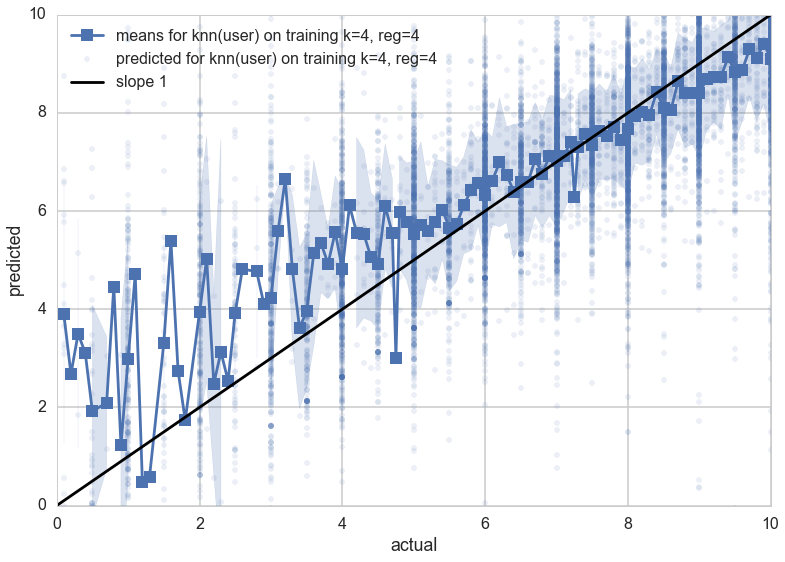

In [38]:
pt, at = get_ratings_user_nbd(train, train, biases, db, k=4, reg=4.)

compare_results(at,pt, model="knn(user) on training k=4, reg=4", predicteds=True)

Now we use our validation set in order to find the optimal k and reg to lower the RMSE.

In [39]:
rmsedict = dict()
for k in np.arange(1,101,10):
    for reg in np.arange(1,101,10):
        pt, at = get_ratings_user_nbd(validate, train, biases, db, k=k, reg=reg)
        rmsedict[(k,reg)] = get_rmse(pt,at)

In [40]:
mintup=min(rmsedict, key=rmsedict.get)
mintup

(41, 91)

In [41]:
for k in np.arange(mintup[0]-10,mintup[0]+10,5):
    for reg in np.arange(mintup[1]-10,mintup[1]+10,5):
        pt, at = get_ratings_user_nbd(validate, train, biases, db, k=k, reg=reg)
        rmsedict[(k,reg)] = get_rmse(pt,at)

In [42]:
mintup=min(rmsedict, key=rmsedict.get)
mintup

(41, 96)

In [43]:
predictions['knn'],at = get_ratings_user_nbd(test, train, biases, db, k=mintup[0], reg=float(mintup[1]))
predictions_valid['knn'],v_at = get_ratings_user_nbd(validate, validate, biases, db, k=mintup[0], reg=float(mintup[1]))

RMSE for baseline 2.37843372483
RMSE for knn 2.14458292229


(<matplotlib.axes._subplots.AxesSubplot at 0x1840e6850>, 2.1445829222910624)

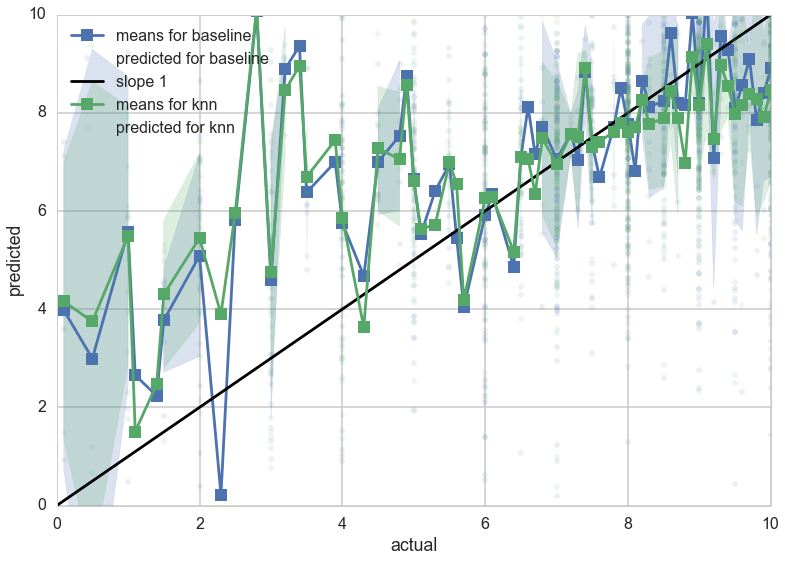

In [44]:
ax, rmse = compare_results(test.overall,predictions['baseline'], model="baseline", predicteds=True)
compare_results(test.overall,predictions['knn'], model="knn", predicteds=True,onsame=ax)

Finally, we can see that kNN analysis does improve fairly signicantly on the baseline analysis, but unfortunately still has a high RMSE above 2.  Ultimately we decided that continuing to attempt predictive models would not be fruitful, due to the lack of common supports among users/anime and the sparsity of data.

##Classifier Analysis

Previously, we attempted to predict how users will rate an anime using predictive models. Our preliminary results showed that it was difficult to create a linear model that can accurately predict how users will rate an anime. Thus, we decided to limit our scope to whenether or not a user will like an anime, and attempt to use the SVM classifier to predict this.

### Categorizing Animes into Good or Bad

To do this, we first have to determine how to classify a "good" anime versus a "bad" anime. In our dataset, users have rated animes according to the film's animation, character, sound, story, and overall score. In order to leverage all this information, the average of these scores was taken to determine an overall average score for each anime.

Next, we need to decide on how to categorize good and bad. While we could decide on an arbitary cutoff value, it'll be hard to come up with an arbitary value that would make sense for our data set. For instance, while an average of 5/10 theoretically should an average film, the true average isn't at this value. Thus, we decided to categorize a good anime as having an at or above average score, while bad animes have below average scores. 

In [3]:
final = pd.read_csv('../data/final_review.csv',index_col=0)
final.loc[:,'average'] = np.nanmean(final.loc[:,['animation','character','overall','sound','story']],axis=1)

#deleting unessential columns
df = final.drop(['animation','character','overall','sound','story','anime_name','reviews'],1)

#converting sex to indicator
sex = []

for row in df.index:
    if df.ix[row,'sex']=='M':
        sex.append(1)
    elif df.ix[row,'sex']=='F':
        sex.append(0)
    else:
        sex.append(-1)
        
df.loc[:,'sex'] = sex

In [4]:
mean = df.loc[:,'average'].mean()
mean

7.23730245046724

In [5]:
response = []

for row in df.index:
    if df.ix[row,'average']>=mean:
        response.append(1)
    else:
        response.append(0)
        
df.loc[:,'average'] = response

In [6]:
df.loc[:,'average'].mean()

0.5694428288938002

### Standardize

Now that we have our data matrix set up, we want to explore the relationship of these independent variables with the response variable. In this case, the only non-indicator variable is age, so a KDE plot was set up to look for a separation of response variables. After standardizing the age variable (separately for train and test), and plotting the KDE, it seems that there is a slight separation in age between good and bad animes.

In [7]:
itrain, itest = train_test_split(xrange(df.shape[0]), train_size=0.7)

In [8]:
mask=np.ones(df.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

In [9]:
from sklearn.preprocessing import StandardScaler

valstrain=df['age'].values[mask]
valstest=df['age'].values[~mask]
scaler=StandardScaler().fit(valstrain)
outtrain=scaler.transform(valstrain)
outtest=scaler.fit_transform(valstest)
out=np.empty(mask.shape[0])
out[mask]=outtrain
out[~mask]=outtest
df['age']=out

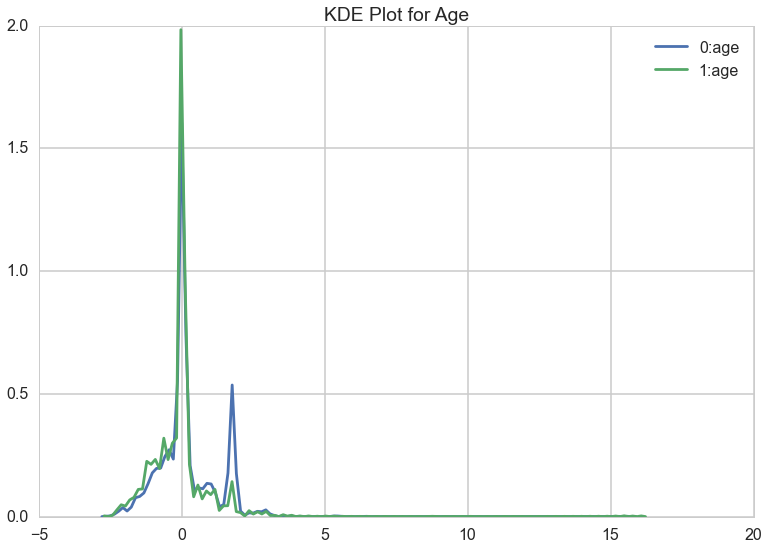

In [10]:
#testing age
dfgb=df.groupby('average')
for k, v in dfgb['age']:
        sns.kdeplot(v, label=str(k)+":"+v.name)
plt.title('KDE Plot for Age')

/Users/tiffanylee/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


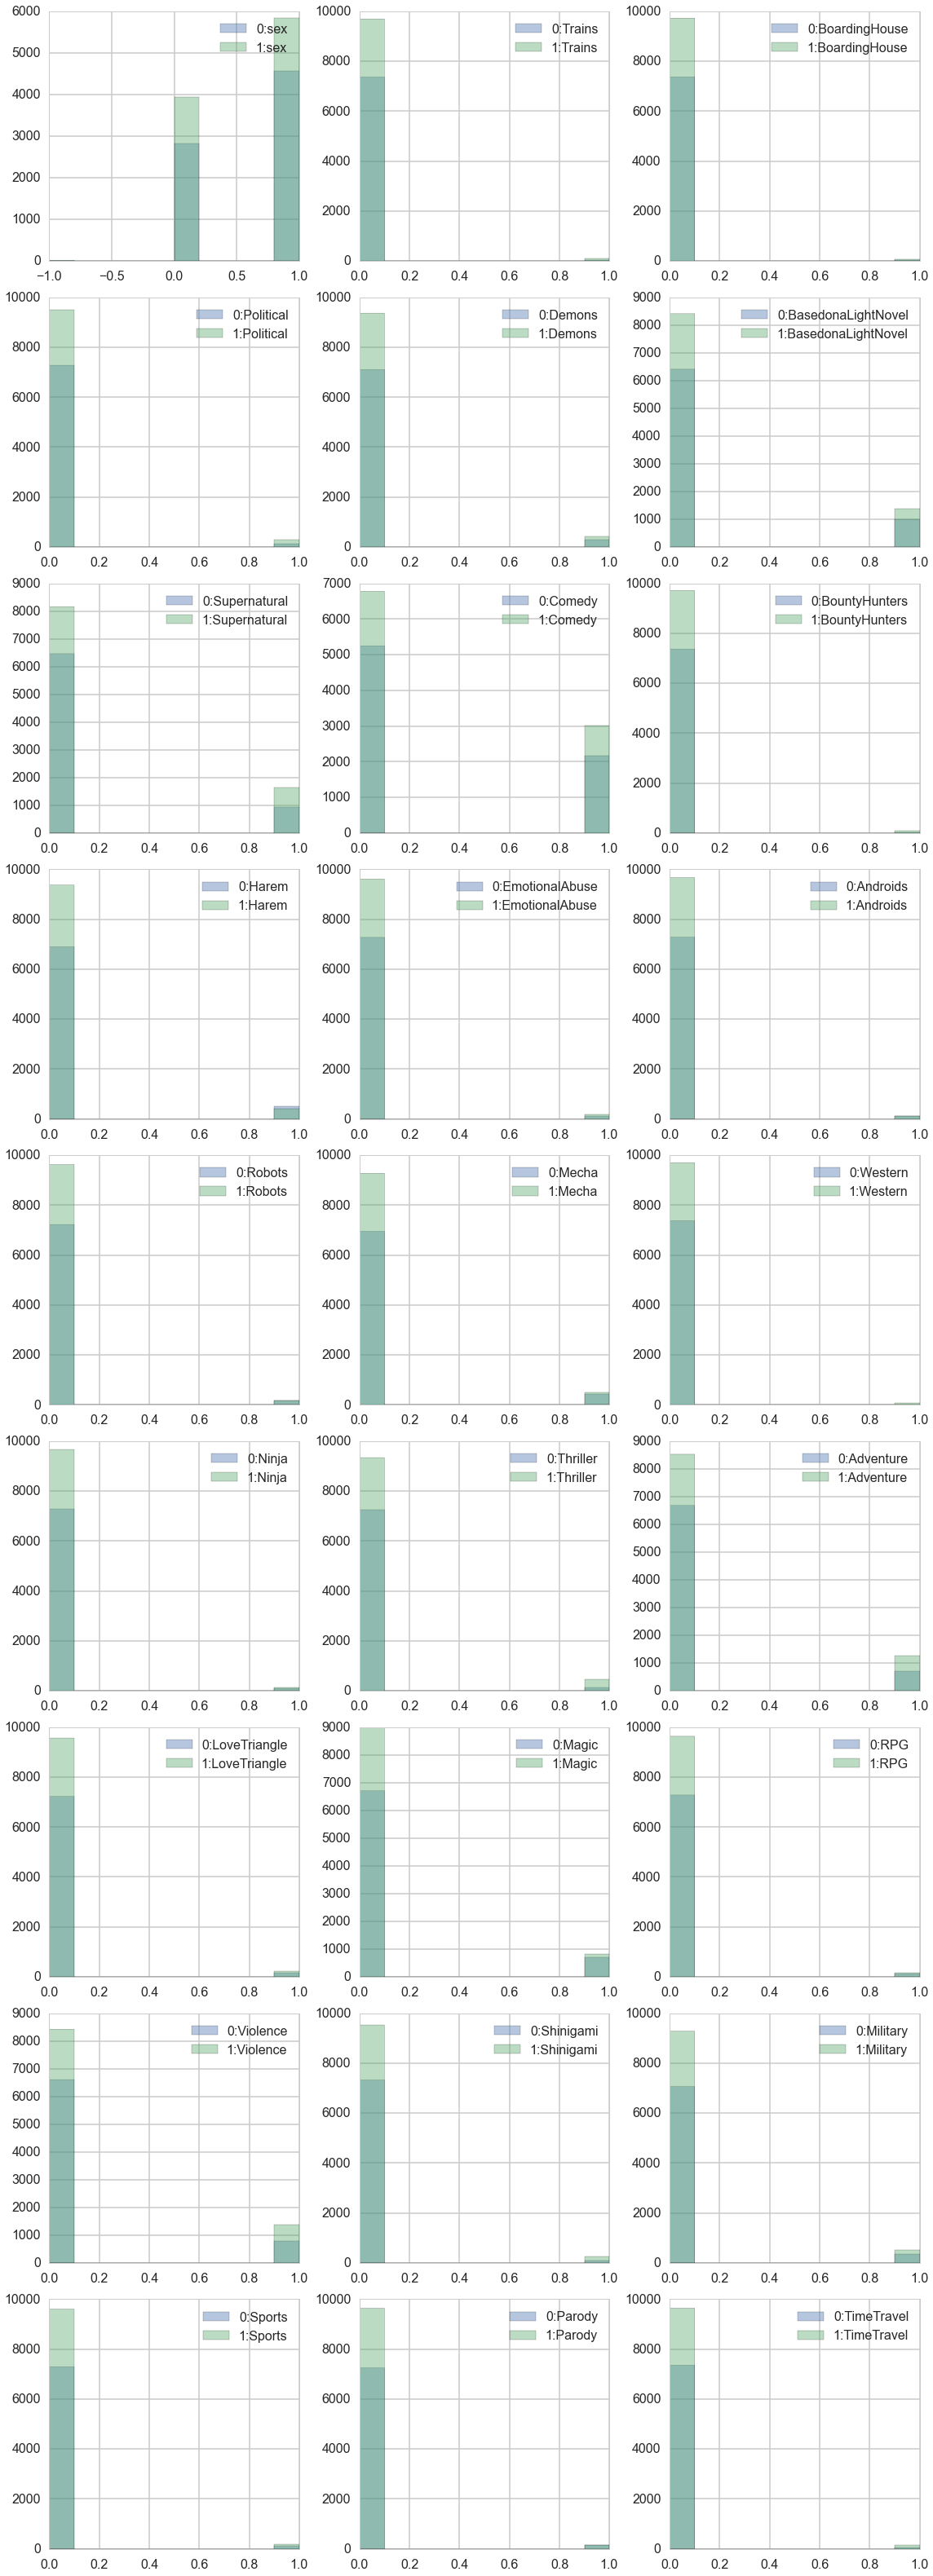

In [11]:
#Histograms of first 27 indicators
fig, axes = plt.subplots(nrows=9, ncols=3, figsize=(16, 44), 
                         tight_layout=True)

INDICATORS = df.columns[3:31].tolist()
for ax, p in zip(axes.ravel(), INDICATORS):
    for k, v in dfgb[p]:
        v.hist(ax=ax, alpha=0.4, label=str(k)+":"+v.name)
        ax.legend()

### Baseline

To be able to compare our classifiers, we first need a baseline. Here, we create two baselines, one that assumes all users dislikes all animes, and another that assumes that all users love all animes. Here, we find that with the training data, the baseline for everyone liking is 56%, and everyone disliking is 43%.

In [12]:
#columns to grab
lcols = df.columns[2:134].tolist()
Xmatrix=df[lcols].values
Yresp=df['average'].values

#creating test and train dataframes
Xmatrix_train=Xmatrix[mask]
Xmatrix_test=Xmatrix[~mask]
Yresp_train=Yresp[mask]
Yresp_test=Yresp[~mask]

In [13]:
#all users like animes
basex_like = np.ones(len(Xmatrix_train))

#all users hate animes
basex_dislike = np.zeros(len(Xmatrix_train))

accuracy_like = [i[0] == i[1] for i in zip(basex_like,Yresp_train)]
accuracy_dislike = [i[0] == i[1] for i in zip(basex_dislike,Yresp_train)]

In [14]:
accuracy_like_score = sum(accuracy_like)/float(len(accuracy_like))
accuracy_dislike_score = sum(accuracy_dislike)/float(len(accuracy_dislike))

In [15]:
accuracy_like_score, accuracy_dislike_score

(0.56992106356460326, 0.43007893643539674)

### Linear SVM

Now it's time to create and test classifiers. We first implement functions to optimize the classifier and calculate the accuracy score.

In [16]:
"""
Function
--------
cv_optimize

Inputs
------
clf : an instance of a scikit-learn classifier
parameters: a parameter grid dictionary thats passed to GridSearchCV (see above)
X: a samples-features matrix in the scikit-learn style
y: the response vectors of 1s and 0s (+ives and -ives)
n_folds: the number of cross-validation folds (default 5)
score_func: a score function we might want to pass (default python None)
   
Returns
-------
The best estimator from the GridSearchCV, after the GridSearchCV has been used to
fit the model.
     
Notes
-----
see do_classify and the code below for an example of how this is used
"""
def cv_optimize(clf, parameters, X, y, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(X, y)
    print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_
    best = gs.best_estimator_
    return best

In [17]:
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask !=None:
        print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest

### Classifiers

Next, we test out different classifiers. Since our main goal is increasing the accuracy of our predictions, the accuracy score will be used to validate our models. Here with test LinearSVC that minimizes hinge loss and squared hinge loss. Here, we see that there is not a significant difference between the two classifiers

In [18]:
%%time
clfsvm, Xtrain, ytrain, Xtest, ytest = do_classify(LinearSVC(loss="squared_hinge"), {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, df,lcols, u'average',1, mask=mask)

using mask
BEST {'C': 0.001} 0.628749480681 [mean: 0.62875, std: 0.01171, params: {'C': 0.001}, mean: 0.61545, std: 0.01652, params: {'C': 0.01}, mean: 0.61197, std: 0.01208, params: {'C': 0.1}, mean: 0.61014, std: 0.01278, params: {'C': 1.0}, mean: 0.60956, std: 0.01340, params: {'C': 10.0}, mean: 0.58122, std: 0.02300, params: {'C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.64
Accuracy on test data:     0.64
########################################################
CPU times: user 12.5 s, sys: 110 ms, total: 12.6 s
Wall time: 12.6 s


/Users/tiffanylee/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [19]:
%%time
clfsvm, Xtrain, ytrain, Xtest, ytest = do_classify(LinearSVC(loss="hinge"), {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, df,lcols, u'average',1, mask=mask)

using mask
BEST {'C': 0.01} 0.626422933112 [mean: 0.58828, std: 0.00236, params: {'C': 0.001}, mean: 0.62642, std: 0.01093, params: {'C': 0.01}, mean: 0.61978, std: 0.01370, params: {'C': 0.1}, mean: 0.61529, std: 0.01395, params: {'C': 1.0}, mean: 0.61039, std: 0.01533, params: {'C': 10.0}, mean: 0.61005, std: 0.00894, params: {'C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.64
Accuracy on test data:     0.63
########################################################
CPU times: user 6.75 s, sys: 82.3 ms, total: 6.83 s
Wall time: 6.84 s


/Users/tiffanylee/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [20]:
reuse_split=dict(Xtrain=Xtrain, Xtest=Xtest, ytrain=ytrain, ytest=ytest)

### Logistic Classifier

In an attempt to improve the linearSVC classifier, we explore using logistic regression with L1 and L2 penalty. Once again, we see a slight improvement in terms of training data, but no difference in test data. Additionally, L1 and L2 performs equally well.

In [21]:
from sklearn.linear_model import LogisticRegression
clflog,_,_,_,_  = do_classify(LogisticRegression(penalty="l1"), {"C": [0.001, 0.01, 0.1, 1, 10, 100]}, df, lcols, u'average', 1, reuse_split=reuse_split)

using reuse split
BEST {'C': 0.1} 0.632654756959 [mean: 0.43008, std: 0.00010, params: {'C': 0.001}, mean: 0.61728, std: 0.01178, params: {'C': 0.01}, mean: 0.63265, std: 0.01442, params: {'C': 0.1}, mean: 0.61221, std: 0.01408, params: {'C': 1}, mean: 0.60856, std: 0.01174, params: {'C': 10}, mean: 0.60798, std: 0.01245, params: {'C': 100}]
############# based on standard predict ################
Accuracy on training data: 0.64
Accuracy on test data:     0.64
########################################################


In [22]:
clflog2,_,_,_,_  = do_classify(LogisticRegression(penalty="l2"), {"C": [0.001, 0.01, 0.1, 1, 10, 100]}, df, lcols, u'average', 1, reuse_split=reuse_split)

using reuse split
BEST {'C': 0.01} 0.628749480681 [mean: 0.61587, std: 0.00756, params: {'C': 0.001}, mean: 0.62875, std: 0.01136, params: {'C': 0.01}, mean: 0.61595, std: 0.01532, params: {'C': 0.1}, mean: 0.61122, std: 0.01269, params: {'C': 1}, mean: 0.60889, std: 0.01247, params: {'C': 10}, mean: 0.60806, std: 0.01252, params: {'C': 100}]
############# based on standard predict ################
Accuracy on training data: 0.64
Accuracy on test data:     0.64
########################################################


In [23]:
def nonzero_lasso(clf):
    featuremask=(clf.coef_ !=0.0)[0]
    return pd.DataFrame(dict(feature=lcols, coef=clf.coef_[0], abscoef=np.abs(clf.coef_[0])))[featuremask].sort('abscoef', ascending=False)

### Feature Selected

In order to explore the logistic classifier, we look into the features selected by lasso, as well as the features that are correlated with the response variable to look for any discrepancies.

In [24]:
lasso_importances=nonzero_lasso(clflog)
lasso_importances.set_index("feature", inplace=True)
lasso_importances.head(10)

,abscoef,coef
feature,,
ComingofAge,0.591195,0.591195
Drama,0.551140,0.551140
Ecchi,0.542992,-0.542992
BasedonaManga,0.529206,0.529206
BasedonaLightNovel,0.492146,0.492146
BasedonaNovel,0.490408,0.490408
SocialMedia,0.476775,0.476775
TimeTravel,0.476585,0.476585
OriginalWork,0.469368,0.469368


In [25]:
from scipy.stats.stats import pearsonr
correlations=[]
dftousetrain=df[mask]
for col in lcols:
    r=pearsonr(dftousetrain[col], dftousetrain['average'])[0]
    correlations.append(dict(feature=col,corr=r, abscorr=np.abs(r)))

bpdf=pd.DataFrame(correlations).sort('abscorr', ascending=False)
bpdf.set_index(['feature'], inplace=True)
bpdf.head(25)

,abscorr,corr
feature,,
age,0.141456,-0.141456
Drama,0.122763,0.122763
Ecchi,0.117463,-0.117463
BasedonaManga,0.093603,0.093603
ComingofAge,0.084392,0.084392
Psychological,0.071604,0.071604
PantyShots,0.071299,-0.071299
Shounen,0.066982,0.066982
Thriller,0.066569,0.066569


### Pipeline

In another attempt to improve our model, we look into pipeline linear classification. However, the results ended up slightly worse than before.

In [26]:
def pearson_scorer(X,y):
    rs=np.zeros(X.shape[1])
    pvals=np.zeros(X.shape[1])
    i=0
    for v in X.T:
        rs[i], pvals[i]=pearsonr(v, y)
        i=i+1
    return np.abs(rs), pvals

In [27]:
selectorlinearsvm = SelectKBest(k=25, score_func=pearson_scorer)
pipelinearsvm = Pipeline([('select', selectorlinearsvm), ('svm', LinearSVC(loss="hinge"))])

In [28]:
pipelinearsvm, _,_,_,_  = do_classify(pipelinearsvm, {"svm__C": [0.00001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, df,lcols, u'average',1, reuse_split=reuse_split)

using reuse split
BEST {'svm__C': 0.01} 0.613294557541 [mean: 0.60083, std: 0.00314, params: {'svm__C': 1e-05}, mean: 0.59734, std: 0.00479, params: {'svm__C': 0.001}, mean: 0.61329, std: 0.01418, params: {'svm__C': 0.01}, mean: 0.60731, std: 0.01570, params: {'svm__C': 0.1}, mean: 0.59917, std: 0.02121, params: {'svm__C': 1.0}, mean: 0.59826, std: 0.02147, params: {'svm__C': 10.0}, mean: 0.59726, std: 0.01255, params: {'svm__C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.62
Accuracy on test data:     0.62
########################################################


In [29]:
# features our pipeline used
np.array(lcols)[pipelinearsvm.get_params()['select'].get_support()]

array(['age', 'Political', 'Supernatural', 'Thriller', 'Adventure',
       'Violence', 'Shinigami', 'JapaneseMythology', 'ClassicalMusic',
       'Romance', 'Terrorism', 'PantyShots', 'Drama', 'Nudity', 'Shounen',
       'SocialMedia', 'Episodic', 'BasedonaManga', 'BasedonaVideoGame',
       'noitaminA', 'Mystery', 'Psychological', 'ComingofAge',
       'AnimalAbuse', 'Ecchi'], 
      dtype='|S26')

In [30]:
# checking for balance in train data
jtrain=np.arange(0, ytrain.shape[0])
n_pos=len(jtrain[ytrain==1])
n_neg=len(jtrain[ytrain==0])
print n_pos, n_neg

6859 5176


### Kernelized SVM

Lastly, we decide to explore a Kernelized SVM to see if there are any improvements. The end results were even worse than the pipeline linear SVM.

In [31]:
selectorsvm2 = SelectKBest(k=25, score_func=pearson_scorer)
pipesvm2 = Pipeline([('select2', selectorsvm2), ('svm2', SVC())])

In [32]:
jtrain_new=np.arange(0, ytrain.shape[0])
ipos_new = np.random.choice(jtrain_new[ytrain==1], 300, replace=False)
ineg_new = np.random.choice(jtrain_new[ytrain==0], 300, replace=False)
subsampled_i=np.concatenate((ipos_new,ineg_new))
Xtrain_new2=Xtrain[subsampled_i]
ytrain_new2=ytrain[subsampled_i]

In [33]:
reuse_split_subsampled=dict(Xtrain=Xtrain_new2, Xtest=Xtest, ytrain=ytrain_new2, ytest=ytest)

In [34]:
%%time
pipesvm2, _,_,_,_  = do_classify(pipesvm2, {"svm2__C": [1e8],
                                              "svm2__gamma":[1e-5, 1e-7, 1e-9]}, 
                                 df,lcols, u'average',1, reuse_split=reuse_split_subsampled)

using reuse split
BEST {'svm2__C': 100000000.0, 'svm2__gamma': 1e-09} 0.578333333333 [mean: 0.56167, std: 0.04848, params: {'svm2__C': 100000000.0, 'svm2__gamma': 1e-05}, mean: 0.56167, std: 0.03100, params: {'svm2__C': 100000000.0, 'svm2__gamma': 1e-07}, mean: 0.57833, std: 0.02014, params: {'svm2__C': 100000000.0, 'svm2__gamma': 1e-09}]
############# based on standard predict ################
Accuracy on training data: 0.60
Accuracy on test data:     0.61
########################################################
CPU times: user 820 ms, sys: 16 ms, total: 836 ms
Wall time: 858 ms


In [35]:
%%time
gamma_wanted=pipesvm2.get_params()['svm2__gamma']
C_chosen=pipesvm2.get_params()['svm2__C']
print gamma_wanted, C_chosen
selectorsvm3 = SelectKBest(k=25, score_func=pearson_scorer)
pipesvm3 = Pipeline([('select3', selectorsvm3), ('svm3', SVC(C=C_chosen, gamma=gamma_wanted))])
pipesvm3, _,_,_,_  = do_classify(pipesvm3, None, 
                                 df,lcols, u'average',1, reuse_split=reuse_split)

1e-09 100000000.0
using reuse split
############# based on standard predict ################
Accuracy on training data: 0.51
Accuracy on test data:     0.50
########################################################
CPU times: user 12.6 s, sys: 236 ms, total: 12.9 s
Wall time: 13 s


### Conclusion

The linear SVM and logistic regression did the best, with an accuracy score of around 64% for both the train and test data. In comparison, the pipeline linear SVM did slightly worse at 63%, while the kernalized SVM did really poorly at around 56% accuracy. Overall, our models (besides kernalized SVM) are above the 56% baseline of guessing that everyone likes animes. Our linear SVM and logistic regression were actually 8% higher than the baseline.

Results:
1. Baseline - everyone likes animes: 56%
2. Baseline - everyone dislikes animes: 43%
3. Linear SVM - L1 and L2: 64% (8% higher than baseline)
4. Logistic Regression: 64% (8% higher than baseline)
5. Pipeline Linear SVM: 63% (7% higher than baseline)
6. Kernelized SVM: 56% (0% higher than baseline)

Improvements:
1. Add more features such as user's preferences, user's location, user's history
2. Collect more data points (increase data size)
3. Explore non-linear classifiers

### Setting Up Predicting Function

For personal interest, we wanted to create a function that will predict whenether or not someone will like an anime based on existing data. Here, we create said function that takes in user age, sex, and anime, and outputs 1 if user will like anime, or 0 if user won't like anime. Since this uses our best classifier (logistic regression), it will only have a 64% chance of predicting the right results. Nonetheless, we've shown that this still beats the baseline of assuming that all users will like the anime.

In [36]:
mean = final.age.mean()
std = final.age.std()
category = df.columns[4:-1].tolist()
anime_info = pd.read_csv('../data/anime_category.csv',sep='\t',encoding='utf-8',index_col=0)

In [37]:
"""
Function
--------
predict

Inputs
------
age: age of user (int)
sex: sex of user (int: 1=Male, 0=Female, -1=Other)
anime: name of anime (string)
   
Returns
-------
1 if user will like the anime (defined as rating above average rating)
0 if user will not like the anime (below average rating)
"""


def predict(age,sex,anime,clf):
    mean = final.age.mean()
    std = final.age.std()
    category = df.columns[4:-1].tolist()
    anime_info = pd.read_csv('../data/anime_category.csv',sep='\t',encoding='utf-8',index_col=0)
    
    age = (age-mean)/std
    
    user = np.array([age,sex]+anime_info.loc[anime].values.tolist())
    
    return clf.predict(user)[0]

In [38]:
predict(21,0,'Dragoon',clflog)

0

##Textual Reviews Analysis

In [2]:
reviewsdf=pd.read_csv("../data/all_reviews.csv",sep='\t', index_col=0)

Let us do some textual analysis of some of the reviews. First, we make sure Spark is working. 

In [3]:
import findspark
findspark.init()
print findspark.find()

/usr/local/opt/apache-spark/libexec


In [4]:
import pyspark
conf = (pyspark.SparkConf()
    .setMaster('local')
    .setAppName('pyspark')
    .set("spark.executor.memory", "2g"))
sc = pyspark.SparkContext(conf=conf)

In [5]:
import sys
rdd = sc.parallelize(xrange(10),10)
rdd.map(lambda x: sys.version).collect()

['2.7.10 |Anaconda 2.3.0 (x86_64)| (default, Oct 19 2015, 18:31:17) \n[GCC 4.2.1 (Apple Inc. build 5577)]',
 '2.7.10 |Anaconda 2.3.0 (x86_64)| (default, Oct 19 2015, 18:31:17) \n[GCC 4.2.1 (Apple Inc. build 5577)]',
 '2.7.10 |Anaconda 2.3.0 (x86_64)| (default, Oct 19 2015, 18:31:17) \n[GCC 4.2.1 (Apple Inc. build 5577)]',
 '2.7.10 |Anaconda 2.3.0 (x86_64)| (default, Oct 19 2015, 18:31:17) \n[GCC 4.2.1 (Apple Inc. build 5577)]',
 '2.7.10 |Anaconda 2.3.0 (x86_64)| (default, Oct 19 2015, 18:31:17) \n[GCC 4.2.1 (Apple Inc. build 5577)]',
 '2.7.10 |Anaconda 2.3.0 (x86_64)| (default, Oct 19 2015, 18:31:17) \n[GCC 4.2.1 (Apple Inc. build 5577)]',
 '2.7.10 |Anaconda 2.3.0 (x86_64)| (default, Oct 19 2015, 18:31:17) \n[GCC 4.2.1 (Apple Inc. build 5577)]',
 '2.7.10 |Anaconda 2.3.0 (x86_64)| (default, Oct 19 2015, 18:31:17) \n[GCC 4.2.1 (Apple Inc. build 5577)]',
 '2.7.10 |Anaconda 2.3.0 (x86_64)| (default, Oct 19 2015, 18:31:17) \n[GCC 4.2.1 (Apple Inc. build 5577)]',
 '2.7.10 |Anaconda 2.3.0 (x8

In [6]:
sys.version

'2.7.10 |Anaconda 2.3.0 (x86_64)| (default, Oct 19 2015, 18:31:17) \n[GCC 4.2.1 (Apple Inc. build 5577)]'

In [7]:
from pyspark.sql import SQLContext
sqlsc=SQLContext(sc)

Some initial information such as the number of reviews and columns.

In [8]:
print "How many reviews do we have?", reviewsdf.count()

How many reviews do we have? animation     17194
anime         17194
anime_name    17194
character     17194
name          17194
overall       17194
reviews        9382
sound         17194
story         17194
dtype: int64


For the sake of this section, we only care about those reviews that have textual reviews along with the rating itself. 

In [9]:
reviewsdf['reviews'].replace('', np.nan, inplace=True)
reviewsdf.dropna(subset=['reviews'], inplace=True)
reviewsdf.count()

animation     9382
anime         9382
anime_name    9382
character     9382
name          9382
overall       9382
reviews       9382
sound         9382
story         9382
dtype: int64

We now also clean the `overall` column to make it more quantifiable.

In [11]:
reviewsdf['overall'] = reviewsdf['overall'].str.strip('\n/').map(lambda x: float(x[:-4]))
reviewsdf.head(3)

,animation,anime,anime_name,character,name,overall,reviews,sound,story
0,\n10/10,to-aru-majutsu-no-index-10th-anniversary-pv,To Aru Majutsu no Index 10th Anniversary PV,\n10/10,SogiitaGunhaGUTS,10,Well it's a short animation to celebrate Kamac...,\n?/10,\n?/10
2,\n9/10,inazuma-eleven,Inazuma Eleven,\n9/10,xxjacobxx3,9,first of all: I agree with ﻿﻿﻿﻿luminex's revie...,\n9/10,\n9/10
3,\n8/10,inazuma-eleven,Inazuma Eleven,\n6/10,Lumineux,7,Story: 6,\n8/10,\n6/10


To better understand how users are reponsding to specific anime, we want to figure out whether each of the reviews are positive or negative with respect to the user's average rating. We then create a `response` column as well as make a `resarray` so that we can use it for further analysis. The item will be True is the rating is greater than or equal to the user's average rating and False otherwise.

In [12]:
useravgdf = reviewsdf.groupby('name').overall.mean()

In [13]:
def user_average(row):
    return useravgdf[row['name']]

In [14]:
reviewsdf['user_avg'] = reviewsdf.apply(lambda row: user_average(row), axis=1)
reviewsdf['responses'] = reviewsdf.apply((lambda row: row.overall >= row.user_avg), axis=1)

In [15]:
revdf = sqlsc.createDataFrame(reviewsdf)
revdf.cache()

DataFrame[animation: string, anime: string, anime_name: string, character: string, name: string, overall: double, reviews: string, sound: string, story: string, user_avg: double, responses: boolean]

In [16]:
resparray = revdf.map(lambda x: x.overall >= x.user_avg).collect()

Let us now calculate the prior probabiilties for positive and negative.

In [18]:
priorp = np.mean(resparray)
priorn = 1 - priorp
priorp, priorn

(0.67469622681730979, 0.32530377318269021)

###Natural Langauge Processing: Nouns

In [20]:
from pattern.en import parse
from pattern.en import pprint
from pattern.vector import stem, PORTER, LEMMA
punctuation = list('.,;:!?()[]{}`''\"@#$^&*+-|=~_')

from sklearn.feature_extraction import text 
stopwords=text.ENGLISH_STOP_WORDS

import re
regex1=re.compile(r"\.{2,}")
regex2=re.compile(r"\-{2,}")

As in hw5, we implement a `get_parts` function such that it will help simplify sentence parsing. We then find the main words in each sentence so that this will help us when looking at sentiment analysis. 

In [19]:
def get_parts(thetext):
    thetext=re.sub(regex1, ' ', thetext)
    thetext=re.sub(regex2, ' ', thetext)
    nouns=[]
    descriptives=[]
    for i,sentence in enumerate(parse(thetext, tokenize=True, lemmata=True).split()):
        nouns.append([])
        descriptives.append([])
        for token in sentence:
            #print token
            if len(token[4]) >0:
                if token[1] in ['JJ', 'JJR', 'JJS']:
                    if token[4] in stopwords or token[4][0] in punctuation or token[4][-1] in punctuation or len(token[4])==1:
                        continue
                    descriptives[i].append(token[4])
                elif token[1] in ['NN', 'NNS']:
                    if token[4] in stopwords or token[4][0] in punctuation or token[4][-1] in punctuation or len(token[4])==1:
                        continue
                    nouns[i].append(token[4])
    out=zip(nouns, descriptives)
    nouns2=[]
    descriptives2=[]
    for n,d in out:
        if len(n)!=0 and len(d)!=0:
            nouns2.append(n)
            descriptives2.append(d)
    return nouns2, descriptives2

In [21]:
review_parts = revdf.map(lambda x: get_parts(x.reviews))
review_parts.take(1)

[([[u'animation', u'work', u'novelist', u'character', u'series']],
  [[u'short', u'different']])]

In [22]:
%%time
parseout=review_parts.collect()

CPU times: user 137 ms, sys: 87.5 ms, total: 225 ms
Wall time: 1min 10s


In [ ]:
import pickle

with open('tempdata/parseout.pkl', 'wb') as f:
    pickle.dump(parseout, f)


#with open('tempdata/parseout.pkl', 'rb') as f:
#    parseout = pickle.load(f)

In [24]:
ldadatardd=sc.parallelize([ele[0] for ele in parseout]).flatMap(lambda l: l)
ldadatardd.cache()
ldadatardd.take(5)

[[u'animation', u'work', u'novelist', u'character', u'series'],
 [u'review', u'deal', u'truth', u'info'],
 [u'series',
  u'kind',
  u'group',
  u'girl',
  u'mecha',
  u'sport',
  u'slice',
  u'life'],
 [u'girl',
  u'series',
  u'example',
  u'girl',
  u'wand',
  u'transformation',
  u'sequence',
  u'brain',
  u'size',
  u'dumpling'],
 [u'kiddy', u'cliche']]

In [25]:
vocabtups = (ldadatardd.flatMap(lambda word: word)
             .map(lambda word: (word, 1))
             .reduceByKey(lambda a, b: a + b)
             .map(lambda (x,y): x)
             .zipWithIndex()
).cache()

In [26]:
vocab=vocabtups.collectAsMap()
id2word=vocabtups.map(lambda (x,y): (y,x)).collectAsMap()
len(vocab.keys())

9030

Create a Corpus in a bag of words form. That is, we now create the lazy RDD documents so that we have a reference to which kins of words are there. 

In [28]:
import collections

def sentence_tuple(sentence):
    d = collections.defaultdict(int)
    for i in sentence:
        d[vocab[i]] += 1
    return d.items()

documents = ldadatardd.map(sentence_tuple)

Take first 5 to make sure we are doing it correctly. It seems like we are! :D So, we'll collect everything and store it in `corpus`.

In [29]:
documents.take(5)

[[(4937, 1), (7578, 1), (172, 1), (6658, 1), (2366, 1)],
 [(1865, 1), (3853, 1), (870, 1), (4959, 1)],
 [(361, 1),
  (172, 1),
  (4531, 1),
  (3151, 1),
  (5267, 1),
  (5236, 1),
  (1686, 1),
  (8157, 1)],
 [(4872, 1),
  (172, 1),
  (5267, 2),
  (8919, 1),
  (89, 1),
  (3386, 1),
  (2963, 1),
  (93, 1),
  (185, 1)],
 [(2941, 1), (3902, 1)]]

In [30]:
corpus=documents.collect()

Now, we carry out the LDA algorithm on the nouns to see the kinds of themes the reviews seem to be focusing on. We will extract 2 topics to see if find any distinct ones. Note that because there warnings when we set `passes = 1`, also tried setting to `passes = 10` to see if the found topics would be potentially different.

In [31]:
import gensim
lda2 = gensim.models.ldamodel.LdaModel(corpus = corpus, id2word = id2word, num_topics = 2, update_every = 1, chunksize = 20000, passes = 1)

In [32]:
lda2.print_topics()

[u'0.040*story + 0.033*anime + 0.033*character + 0.019*time + 0.016*episode + 0.011*animation + 0.011*series + 0.011*plot + 0.010*thing + 0.010*way',
 u'0.074*anime + 0.038*character + 0.027*series + 0.026*story + 0.024*episode + 0.012*thing + 0.011*season + 0.011*time + 0.011*animation + 0.009*way']

In [33]:
lda2_pass10 = gensim.models.ldamodel.LdaModel(corpus = corpus, id2word = id2word, num_topics = 2, update_every = 1, chunksize = 20000, passes = 10)

In [34]:
lda2_pass10.print_topics()

[u'0.086*anime + 0.054*story + 0.019*animation + 0.017*season + 0.015*series + 0.014*character + 0.013*movie + 0.013*review + 0.012*girl + 0.012*lot',
 u'0.062*character + 0.043*episode + 0.026*series + 0.020*time + 0.019*anime + 0.017*way + 0.012*thing + 0.011*end + 0.010*plot + 0.010*person']

In [35]:
for bow in corpus[0:100:10]:
    print bow
    print lda2.get_document_topics(bow)
    print " ".join([id2word[e[0]] for e in bow])
    print "=========================================="

[(4937, 1), (7578, 1), (172, 1), (6658, 1), (2366, 1)]
[(0, 0.4784098247275097), (1, 0.5215901752724903)]
character animation series novelist work
[(2022, 1), (3912, 1), (5674, 1), (2411, 1), (589, 1), (4173, 1), (4308, 1), (5276, 1)]
[(0, 0.916703169333283), (1, 0.083296830666717045)]
dungeon wizard videogame order minute talk party monster
[(1241, 1), (2761, 1), (1058, 1), (870, 1), (735, 1)]
[(0, 0.13409838224297654), (1, 0.86590161775702346)]
bias anime favorite review largeâ element
[(2761, 1), (1181, 1), (7542, 1)]
[(0, 0.21318321400807111), (1, 0.78681678599192884)]
anime favor season
[(693, 1), (870, 1)]
[(0, 0.70837705709410625), (1, 0.29162294290589386)]
manga review
[(1649, 1), (2945, 1)]
[(0, 0.26118485105280159), (1, 0.73881514894719835)]
line stars.â 
[(8784, 1), (4520, 1), (324, 1), (541, 1), (262, 1)]
[(0, 0.66822238154317903), (1, 0.33177761845682086)]
opening credit nature roll episode
[(8867, 1), (6780, 1)]
[(0, 0.7813134753984371), (1, 0.21868652460156288)]
student 

In [36]:
for bow in corpus[0:100:10]:
    print bow
    print lda2_pass10.get_document_topics(bow)
    print " ".join([id2word[e[0]] for e in bow])
    print "=========================================="

[(4937, 1), (7578, 1), (172, 1), (6658, 1), (2366, 1)]
[(0, 0.45968268615281765), (1, 0.54031731384718229)]
character animation series novelist work
[(2022, 1), (3912, 1), (5674, 1), (2411, 1), (589, 1), (4173, 1), (4308, 1), (5276, 1)]
[(0, 0.068271820827532012), (1, 0.93172817917246797)]
dungeon wizard videogame order minute talk party monster
[(1241, 1), (2761, 1), (1058, 1), (870, 1), (735, 1)]
[(0, 0.71456802911434991), (1, 0.28543197088565003)]
bias anime favorite review largeâ element
[(2761, 1), (1181, 1), (7542, 1)]
[(0, 0.85606139686118643), (1, 0.14393860313881357)]
anime favor season
[(693, 1), (870, 1)]
[(0, 0.8237580663602927), (1, 0.17624193363970728)]
manga review
[(1649, 1), (2945, 1)]
[(0, 0.82836567633492564), (1, 0.17163432366507428)]
line stars.â 
[(8784, 1), (4520, 1), (324, 1), (541, 1), (262, 1)]
[(0, 0.097271452044140935), (1, 0.90272854795585911)]
opening credit nature roll episode
[(8867, 1), (6780, 1)]
[(0, 0.17176612680062034), (1, 0.82823387319937958)]
stu

It turns out that going through a different number of passes does not change much. Although some of the coefficients are different, we see that the words themselves did not change much within the two topics. 

One thing that we do see, however, is that the topics seem to be very similar in scope. This is evidenced by the large number words occuring in both topics, such as "anime", "story", and "character". This also implies that the topics reviewers focuses on are largely the same, and it may be too difficult to distinguish between topics because they are so similar to each other.

However, we should also note that there was a warning saying that there is a sparse amount of data that we have. This is probably an indicator that there is not enough data to find distinct topics.

Regardless of that, we can still try to make some minor conclusions. For one, Topic 0 focuses more on the storyline or the plot of the anime in question whereas the other one could be focusing more on the series/episode as a whole. That is, one is more about specifics of an anime whereas another one could be an overall judgement of an anime.

###Sentiment Analysis with Naive Bayes

First extract the adjectives in the sentences and create a RRD just like we did for the nouns. Then, create the adjective vocabulary for Naive Bayes Classifier.

In [37]:
nbdatardd=sc.parallelize([ele[1] for ele in parseout])
nbdatardd.cache()
nbdatardd.take(10)
#nbdatardd=nbdatardd.flatMap(lambda word: word)

[[[u'short', u'different']],
 [[u'great']],
 [],
 [],
 [[u'anime', u'cliche-ridden', u'magical'],
  [u'magical', u'prepubescent', u'colorful', u'long', u'chinese'],
  [u'dear']],
 [[u'good'],
  [u'small'],
  [u'funny\xe2\xa0and', u'is\xe2\xa0an', u'alternate'],
  [u'hotspring']],
 [[u'entire', u'normal']],
 [[u'old', u'anime', u'heroic', u'evil'], [u'old'], [u'simple', u'short']],
 [[u'beautiful'],
  [u'anime', u'different'],
  [u'mysterious', u'dense'],
  [u'clear', u'consistent'],
  [u'hard-boiled', u'common', u'alternate', u'mystical']],
 [[u'original'], [u'particular', u'favorite', u'aforementioned']]]

In [38]:
tempdd= nbdatardd.flatMap(lambda word: word)
tempdd.flatMap(lambda word: word).take(5)

[u'short', u'different', u'great', u'anime', u'cliche-ridden']

In [39]:
#tempdd= nbdatardd.flatMap(lambda word: word)
#tempdd.flatMap(lambda word: word)

adjvocabtups = (nbdatardd.flatMap(lambda l: l).flatMap(lambda word: word)
             .map(lambda word: (word, 1))
             .reduceByKey(lambda a, b: a + b)
             .map(lambda (x,y): x)
             .zipWithIndex()
).cache()

#ldadatardd.flatMap(lambda word: word).take(5)

adjvocab  = adjvocabtups.collectAsMap()

len(adjvocab)

4840

First flatten the list of sentences as a list of all the adjectives in a certain review. Afterwards, we start doing a classifier of whether the reviews are positive or negative. We must first split our data into test and training sets. Note that because the outputs from these are Spark arrays, we must convert them into numpy arrays. 

In [40]:
import itertools
Xarraypre=nbdatardd.map(lambda l: " ".join(list(itertools.chain.from_iterable(l))))
Xarray=Xarraypre.collect()
print Xarray[0]

short different


In [41]:
from sklearn.cross_validation import train_test_split
itrain, itest = train_test_split(xrange(len(Xarray)), train_size=0.7)
mask=np.ones(len(Xarray), dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

In [42]:
X=np.array(Xarray)
y=np.array(resparray)

Like we did in the previous section, we also need to bag-of-words representation.

In [43]:
def make_xy(X_col, y_col, vectorizer):
    X = vectorizer.fit_transform(X_col)
    y = y_col
    return X, y

We use three helper functions so that we can implement Naive Bayes Classifier. All of these are based on functions and ideas presented in homework 5.

(a) Log-likelihood function. We need to be able to determine the log-likelihood of a dataset. 

(b) Cross-Validation function to help with the classifying pipeline. 

(c) Calibration Plot function to make the actual graph

In [44]:
"""
Function
--------
log_likelihood

Compute the log likelihood of a dataset according to 
a Naive Bayes classifier. 
The Log Likelihood is defined by

L = Sum_positive(logP(positive)) + Sum_negative(logP(negative))

Where Sum_positive indicates a sum over all positive reviews, 
and Sum_negative indicates a sum over negative reviews

Parameters
----------
clf : Naive Bayes classifier
x : (nexample, nfeature) array
    The input data
y : (nexample) integer array
    Whether each review is Fresh
"""
def log_likelihood(clf, x, y):
    prob = clf.predict_log_proba(x)
    neg = y == 0
    pos = ~neg
    return prob[neg, 0].sum() + prob[pos, 1].sum()

In [45]:
from sklearn.cross_validation import KFold

def cv_score(clf, x, y, score_func, nfold=5):
    """
    Uses 5-fold cross validation to estimate a score of a classifier
    
    Inputs
    ------
    clf : Classifier object
    x : Input feature vector
    y : Input class labels
    score_func : Function like log_likelihood, that takes (clf, x, y) as input,
                 and returns a score
                 
    Returns
    -------
    The average score obtained by splitting (x, y) into 5 folds of training and 
    test sets, fitting on the training set, and evaluating score_func on the test set
    
    Examples
    cv_score(clf, x, y, log_likelihood)
    """
    result = 0
    for train, test in KFold(y.size, nfold): # split data into train/test groups, 5 times
        clf.fit(x[train], y[train]) # fit
        result += score_func(clf, x[test], y[test]) # evaluate score function on held-out data
    return result / nfold # average

In [46]:
def calibration_plot(clf, xtest, ytest):
    prob = clf.predict_proba(xtest)[:, 1]
    outcome = ytest
    data = pd.DataFrame(dict(prob=prob, outcome=outcome))

    #group outcomes into bins of similar probability
    bins = np.linspace(0, 1, 20)
    cuts = pd.cut(prob, bins)
    binwidth = bins[1] - bins[0]
    
    #freshness ratio and number of examples in each bin
    cal = data.groupby(cuts).outcome.agg(['mean', 'count'])
    cal['pmid'] = (bins[:-1] + bins[1:]) / 2
    cal['sig'] = np.sqrt(cal.pmid * (1 - cal.pmid) / cal['count'])
        
    #the calibration plot
    ax = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    p = plt.errorbar(cal.pmid, cal['mean'], cal['sig'])
    plt.plot(cal.pmid, cal.pmid, linestyle='--', lw=1, color='k')
    plt.ylabel("Empirical P(+)")
    
    #the distribution of P(+)
    ax = plt.subplot2grid((3, 1), (2, 0), sharex=ax)
    
    plt.bar(left=cal.pmid - binwidth / 2, height=cal['count'],
            width=.95 * (bins[1] - bins[0]),
            fc=p[0].get_color())
    
    plt.xlabel("Predicted P(+)")
    plt.ylabel("Number")

In [47]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

We now implement the cross-validation loop such that we can find the optimal alpha and min_df variables. 

In [48]:
#the grid of parameters to search over
alphas = [.1, 1, 5, 10, 50]
min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

# Adapted from Lab 10
# Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df = None
maxscore=-np.inf
for alpha in alphas:
    for min_df in min_dfs:         
        vectorizer = CountVectorizer(min_df = min_df, vocabulary = adjvocab)       
        Xthis, ythis = make_xy(X, y.transpose(), vectorizer)
        Xtrainthis=Xthis[mask]
        ytrainthis=ythis[mask]
        
        clf = MultinomialNB(alpha=alpha)
        cvscore = cv_score(clf, Xtrainthis, ytrainthis, log_likelihood)

        if cvscore > maxscore:
            maxscore = cvscore
            best_alpha, best_min_df = alpha, min_df

In [49]:
print "alpha: %f" % best_alpha
print "min_df: %f" % best_min_df

alpha: 1.000000
min_df: 0.000010


Accuracy on training data: 0.75
Accuracy on test data:     0.66


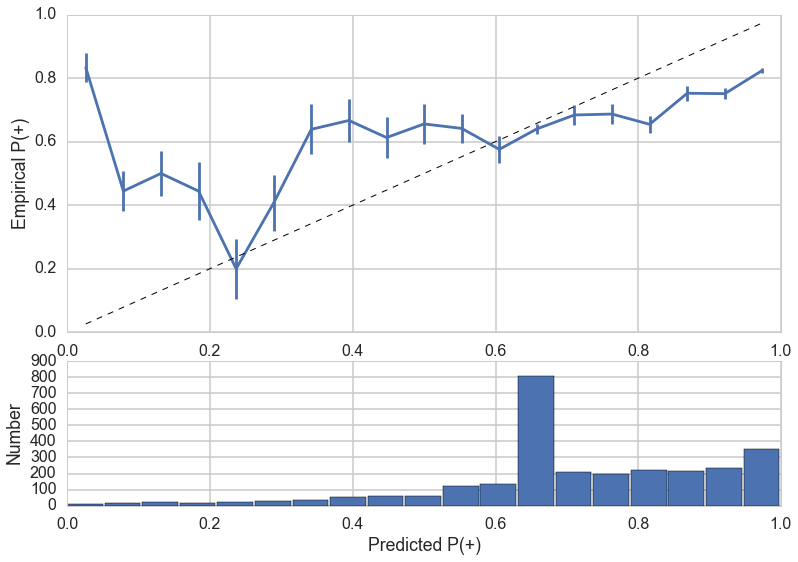

In [53]:
vectorizer = CountVectorizer(min_df=best_min_df,vocabulary=adjvocab)
best_X, best_y = make_xy(X, y, vectorizer)
xtrain=best_X[mask]
ytrain=best_y[mask]
xtest=best_X[~mask]
ytest=best_y[~mask]

best_clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print "Accuracy on training data: %0.2f" % (training_accuracy)
print "Accuracy on test data:     %0.2f" % (test_accuracy)

calibration_plot(clf, xtest, ytest)

We see that there is an underestimate, since the slope of this curve is almost non-existent. 

###Sentiment Analysis

First we want to find the log-probabilities for adjectives, one for the positives and one for the negatives. 

In [54]:
best_clf.feature_log_prob_.shape

(2, 4840)

In [55]:
logpositives = dict(zip(vectorizer.get_feature_names(), best_clf.feature_log_prob_[1]))
lognegatives = dict(zip(vectorizer.get_feature_names(), best_clf.feature_log_prob_[0]))

We then attempt to find the probability that a certain sentence is positive using Naive Bayes and Bayes rule. However, in order for us to do this, we also compute which topic is better suitable for the sentence. In the end, what is done is that we choose which of the two topics have a higher probability. This is implemented in `choose_topic`. Then, we run a loop to find the sentence topic and the sentiment of the certain sentence in question.

In [56]:
def calc_pplus(adjlist, lp, ln, pp, pn):
    pos = 0
    neg = 0
    for adj in adjlist:
        if adj in lp:
            pos += lp[adj]
        if adj in ln:
            neg += ln[adj]
    p = np.exp(pos)*pp
    n = np.exp(neg)*pn
    return pos / (p + n)

In [57]:
reviews=revdf.map(lambda r: r.name).collect()

In [58]:
def choose_topic(ldamodel, bow):
    tee = lda2.get_document_topics(bow)
    if len(tee)==2:
        t1,t2=tee
        if t2[1] >= t1[1]:#get higher probability topic
            topicis=t2[0]
        else:
            topicis=t1[0]
    elif len(tee)==1:#if only one was provided its very high probability. Take it
        teetuple=tee[0]
        topicis=teetuple[0]
    return topicis

In [59]:
counter=0
reviewdict={}
for i, rid in enumerate(reviews):
    rlist=[]
    nlist, alist = parseout[i]
    ln=len(nlist)
    localbow=corpus[counter:counter+ln]
    for bow, adj, noun in zip(localbow, alist, nlist):
        doc=" ".join([id2word[e[0]] for e in bow])
        pplus=calc_pplus(adj, logpositives, lognegatives, priorp, priorn)
        topicis=choose_topic(lda2, bow)
        ldict={"topic": topicis, 'pplus':pplus}
        rlist.append(ldict)
    reviewdict[rid]=rlist
    counter=counter+ln

In [60]:
def extendit(row):
    outlist=[]
    revs=reviewdict[row.name]
    for r in revs:
        r2=r.copy()
        r2['anime_name']=row.anime_name
        r2['name']=row.name
        r2['overall']=row.overall
        r2['user_avg']=row.user_avg
        outlist.append(r2)
    return outlist

Using these new information, create another dataframe.

In [61]:
%%time
newdfin=revdf.flatMap(lambda r: extendit(r)).cache()

CPU times: user 464 ms, sys: 41 ms, total: 505 ms
Wall time: 708 ms


In [62]:
newdfin.take(2)

[{'anime_name': u'To Aru Majutsu no Index 10th Anniversary PV',
  'name': u'SogiitaGunhaGUTS',
  'overall': 10.0,
  'pplus': -172322.66971661657,
  'topic': 1,
  'user_avg': 10.0},
 {'anime_name': u'Inazuma Eleven',
  'name': u'xxjacobxx3',
  'overall': 9.0,
  'pplus': -4344.1395401957689,
  'topic': 0,
  'user_avg': 7.509302325581395}]

In [63]:
%%time
list_of_dicts=newdfin.collect()

CPU times: user 43 ms, sys: 13.6 ms, total: 56.5 ms
Wall time: 260 ms


In [64]:
completedf=pd.DataFrame(list_of_dicts)
completedf.head()

,anime_name,name,overall,pplus,topic,user_avg
0,To Aru Majutsu no Index 10th Anniversary PV,SogiitaGunhaGUTS,10,-172322.669717,1,10.000000
1,Inazuma Eleven,xxjacobxx3,9,-4344.139540,0,7.509302
2,Inazuma Eleven,Lumineux,7,-29601.490461,1,8.045455
3,Inazuma Eleven,Lumineux,7,-64184.674656,0,8.045455
4,Inazuma Eleven,Lumineux,7,-5914.337697,0,8.045455


If we had more time, the next step would be playing around with these log probabilities to determine the mean and variance of the average sentive of each sentence. With this information, we could potentially find more nuanced tendencies that audience members have. For example, with a higher variance, we can perhaps see that either someone is very inconsistent in the way they present themselves, or it could potentially be a result of human expressions (such as sarcasm and colloquial undertones). 